# KC_Route_Generation
In this notebook, I'll be running through the process of generating a LOT of routes from existing data.

In [104]:
import os
import sys
sys.path.append('../src/reRoute_Dynamics_Core/')
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import shapely.plotting as shapeplt
import pyogrio as pio
import KC_Query_Tools as kqt
import Geography_Tools as gt
import Object_Params as op
import Trip_Simulator as ts
import Instance_Tools as it
import ESS
import multiprocessing

import importlib
importlib.reload(gt)
importlib.reload(op)
importlib.reload(ts)
importlib.reload(it)
importlib.reload(ESS)
importlib.reload(kqt)


# Map path
map_path = '/media/sebastian/Slepnir/KC_Map/map/Incorporated_Areas_of_King_County___citydst_area.shp'

# Use the ridership data to get expected unique riders for a given route, period, and direction!
ridership_data_path = './KC_Example_Data/KC_Route_Data/Ridership/Ridership.csv'

# route data and save directories
route_data_dir = "./KC_Example_Data/KC_Route_Data/"
bound_data = "./KC_Example_Data/KC_Route_Data/Bound_Data/"

dsm_raster_path = "./..//..//..//..//..//..//media/sebastian/Slepnir/Raster_data/KC_West_2021/dsm/"

route_savepath = './KC_Example_Data/Saved_Routes/'

# Bus, ESS, and Trip paths:
bus_save_path = "./KC_Example_Data/Saved_Objects/Busses/"
bus_path = bus_save_path + "XDE35.txt"

ESS_save_path = "./KC_Example_Data/Saved_Objects/ESSes/"
ESS_path = ESS_save_path + "XDE35_ESS.txt"

trip_save_path = "./KC_Example_Data/Saved_Objects/Trips/"
trip_path = trip_save_path + "base_XDE35_trip.txt"

seed_list = np.arange(0, 5, 1)
render_params = (10, 3)

In [3]:
map_path = '/media/sebastian/Slepnir/KC_Map/map/Incorporated_Areas_of_King_County___citydst_area.shp'
def blank_kc_canvas():
    '''
    Plotting method to setup a blank canvas in EPSG:4326 with a map of king county.
    '''
    fig, ax = plt.subplots(1,1,figsize=(10, 10), dpi = 300)
    king_county_map = gpd.read_file(map_path).to_crs(epsg=4326)
    king_county_map.plot(ax=ax, zorder=1, color='#BDBDBD')
    ax.set_xlim(-122.6, -121.0)
    ax.set_ylim(47.05, 47.81)
    return fig, ax

def bind_geodata(data, bounds, how = 'intersects'):
    '''
    bind_geodata takes a shapely polygon as bounds and then returns only the data that
    is bound within those boundaries. You can specify the kind of binding preferred.
    
    Params:
    data - dataframe with at least one 'geometry' column
    bounds - shapely polygon
    how - binding specification. Defualt 'intersects'.
    
    Returns:
    dataframe filtered to that which is contained in the bounds. 
    '''
    if how == 'intersects':
        data['bound'] = data.apply(lambda x: bounds.intersects(x.geometry), axis=1)
        bound_data = data[data['bound'] == True]
        return bound_data
    elif how == 'contains':
        data['bound'] = data.apply(lambda x: bounds.contains(x.geometry), axis=1)
        bound_data = data[data['bound'] == True]
        return bound_data
    else:
        data['bound'] = data.apply(lambda x: bounds.intersects(x.geometry), axis=1)
        bound_data = data[data['bound'] == True]
        return bound_data

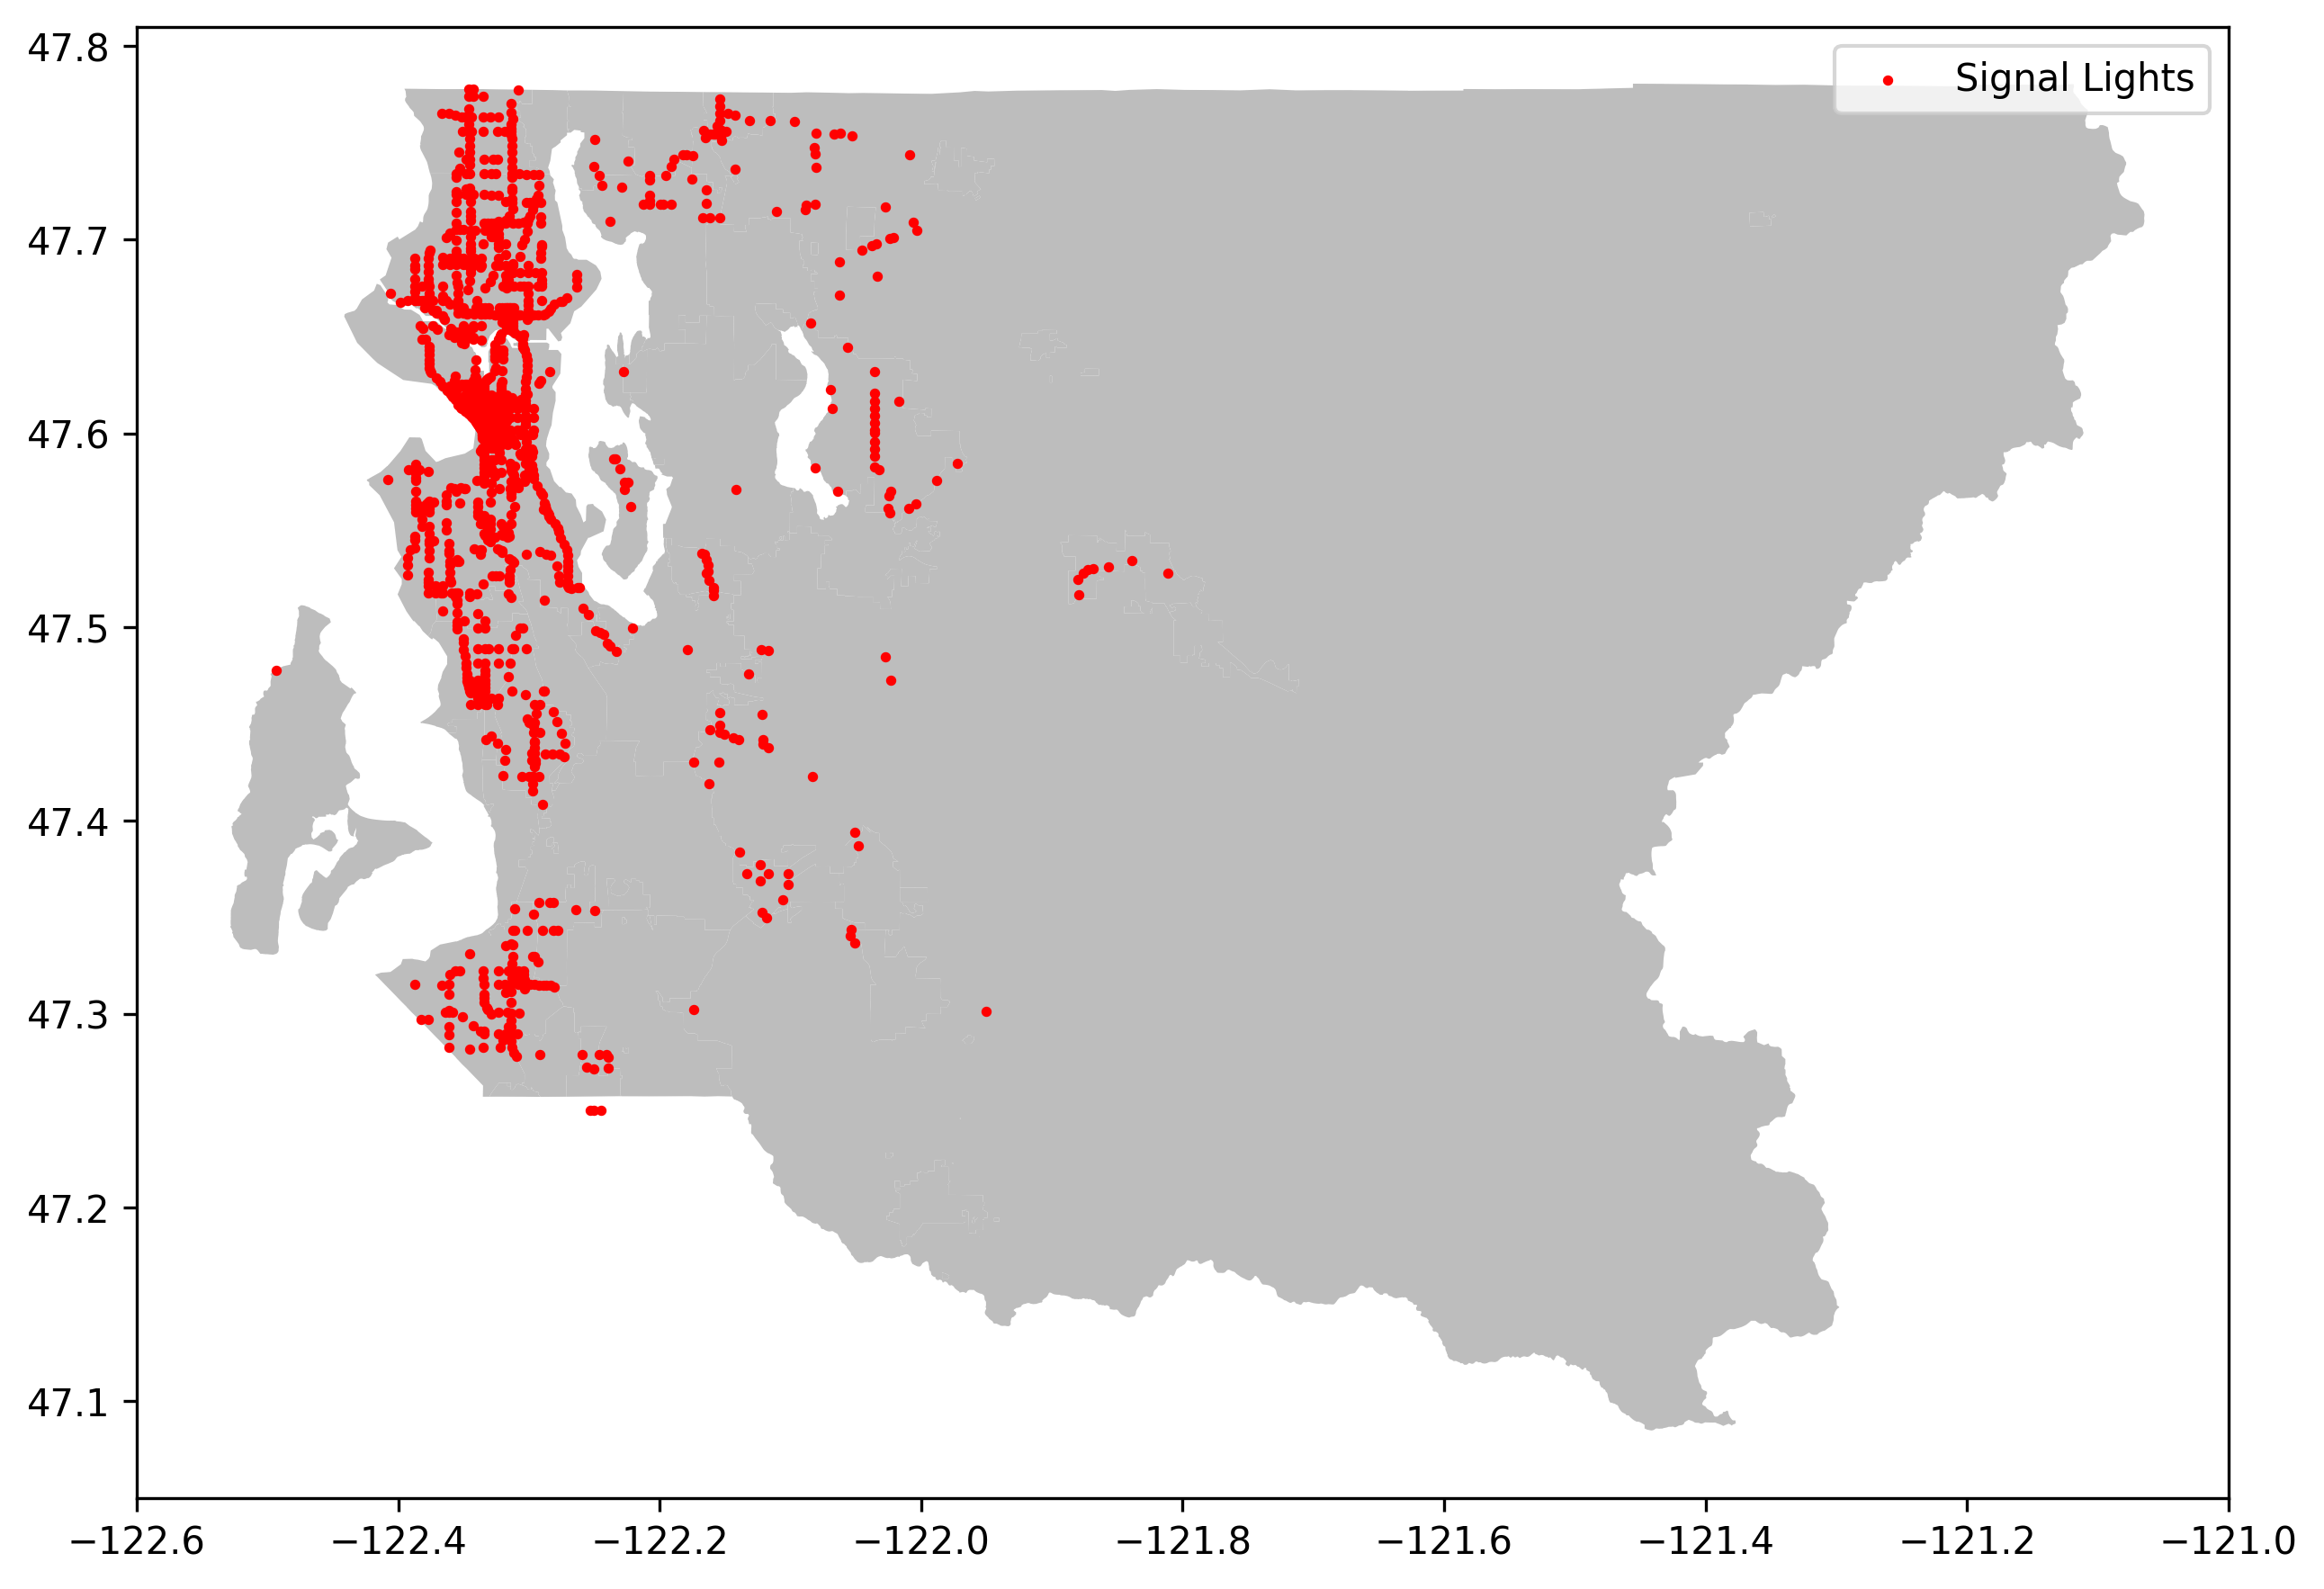

In [4]:
# Load and plot all king county and seattle signals. 

kc_sig = gpd.read_file(route_data_dir + "Signals/KC_Signals.shp")
sea_sig = gpd.read_file(route_data_dir + "Signals/Traffic_Signals.shp")

catsea_sig = sea_sig.filter(['UNITID','geometry'])
catsea_sig['geometry'] = catsea_sig.apply(lambda x: shapely.Point(x['geometry'].geoms[0]),axis=1)
catkc_sig = kc_sig.filter(['SignalID','geometry'])
catsea_sig = catsea_sig.rename(columns={"UNITID":"SIGNAL_ID"})
catsea_sig['SIGNAL_ID'] = catsea_sig['SIGNAL_ID'].apply(lambda x: x if type(x) == type(1) else int(x.split("-")[1])*113)
signals = gpd.GeoDataFrame(pd.concat([catsea_sig,catkc_sig]))

fig, ax = blank_kc_canvas()
signals.plot(ax=ax, c='red',markersize=3, zorder=5)
ax.legend(["Signal Lights"])
plt.show()

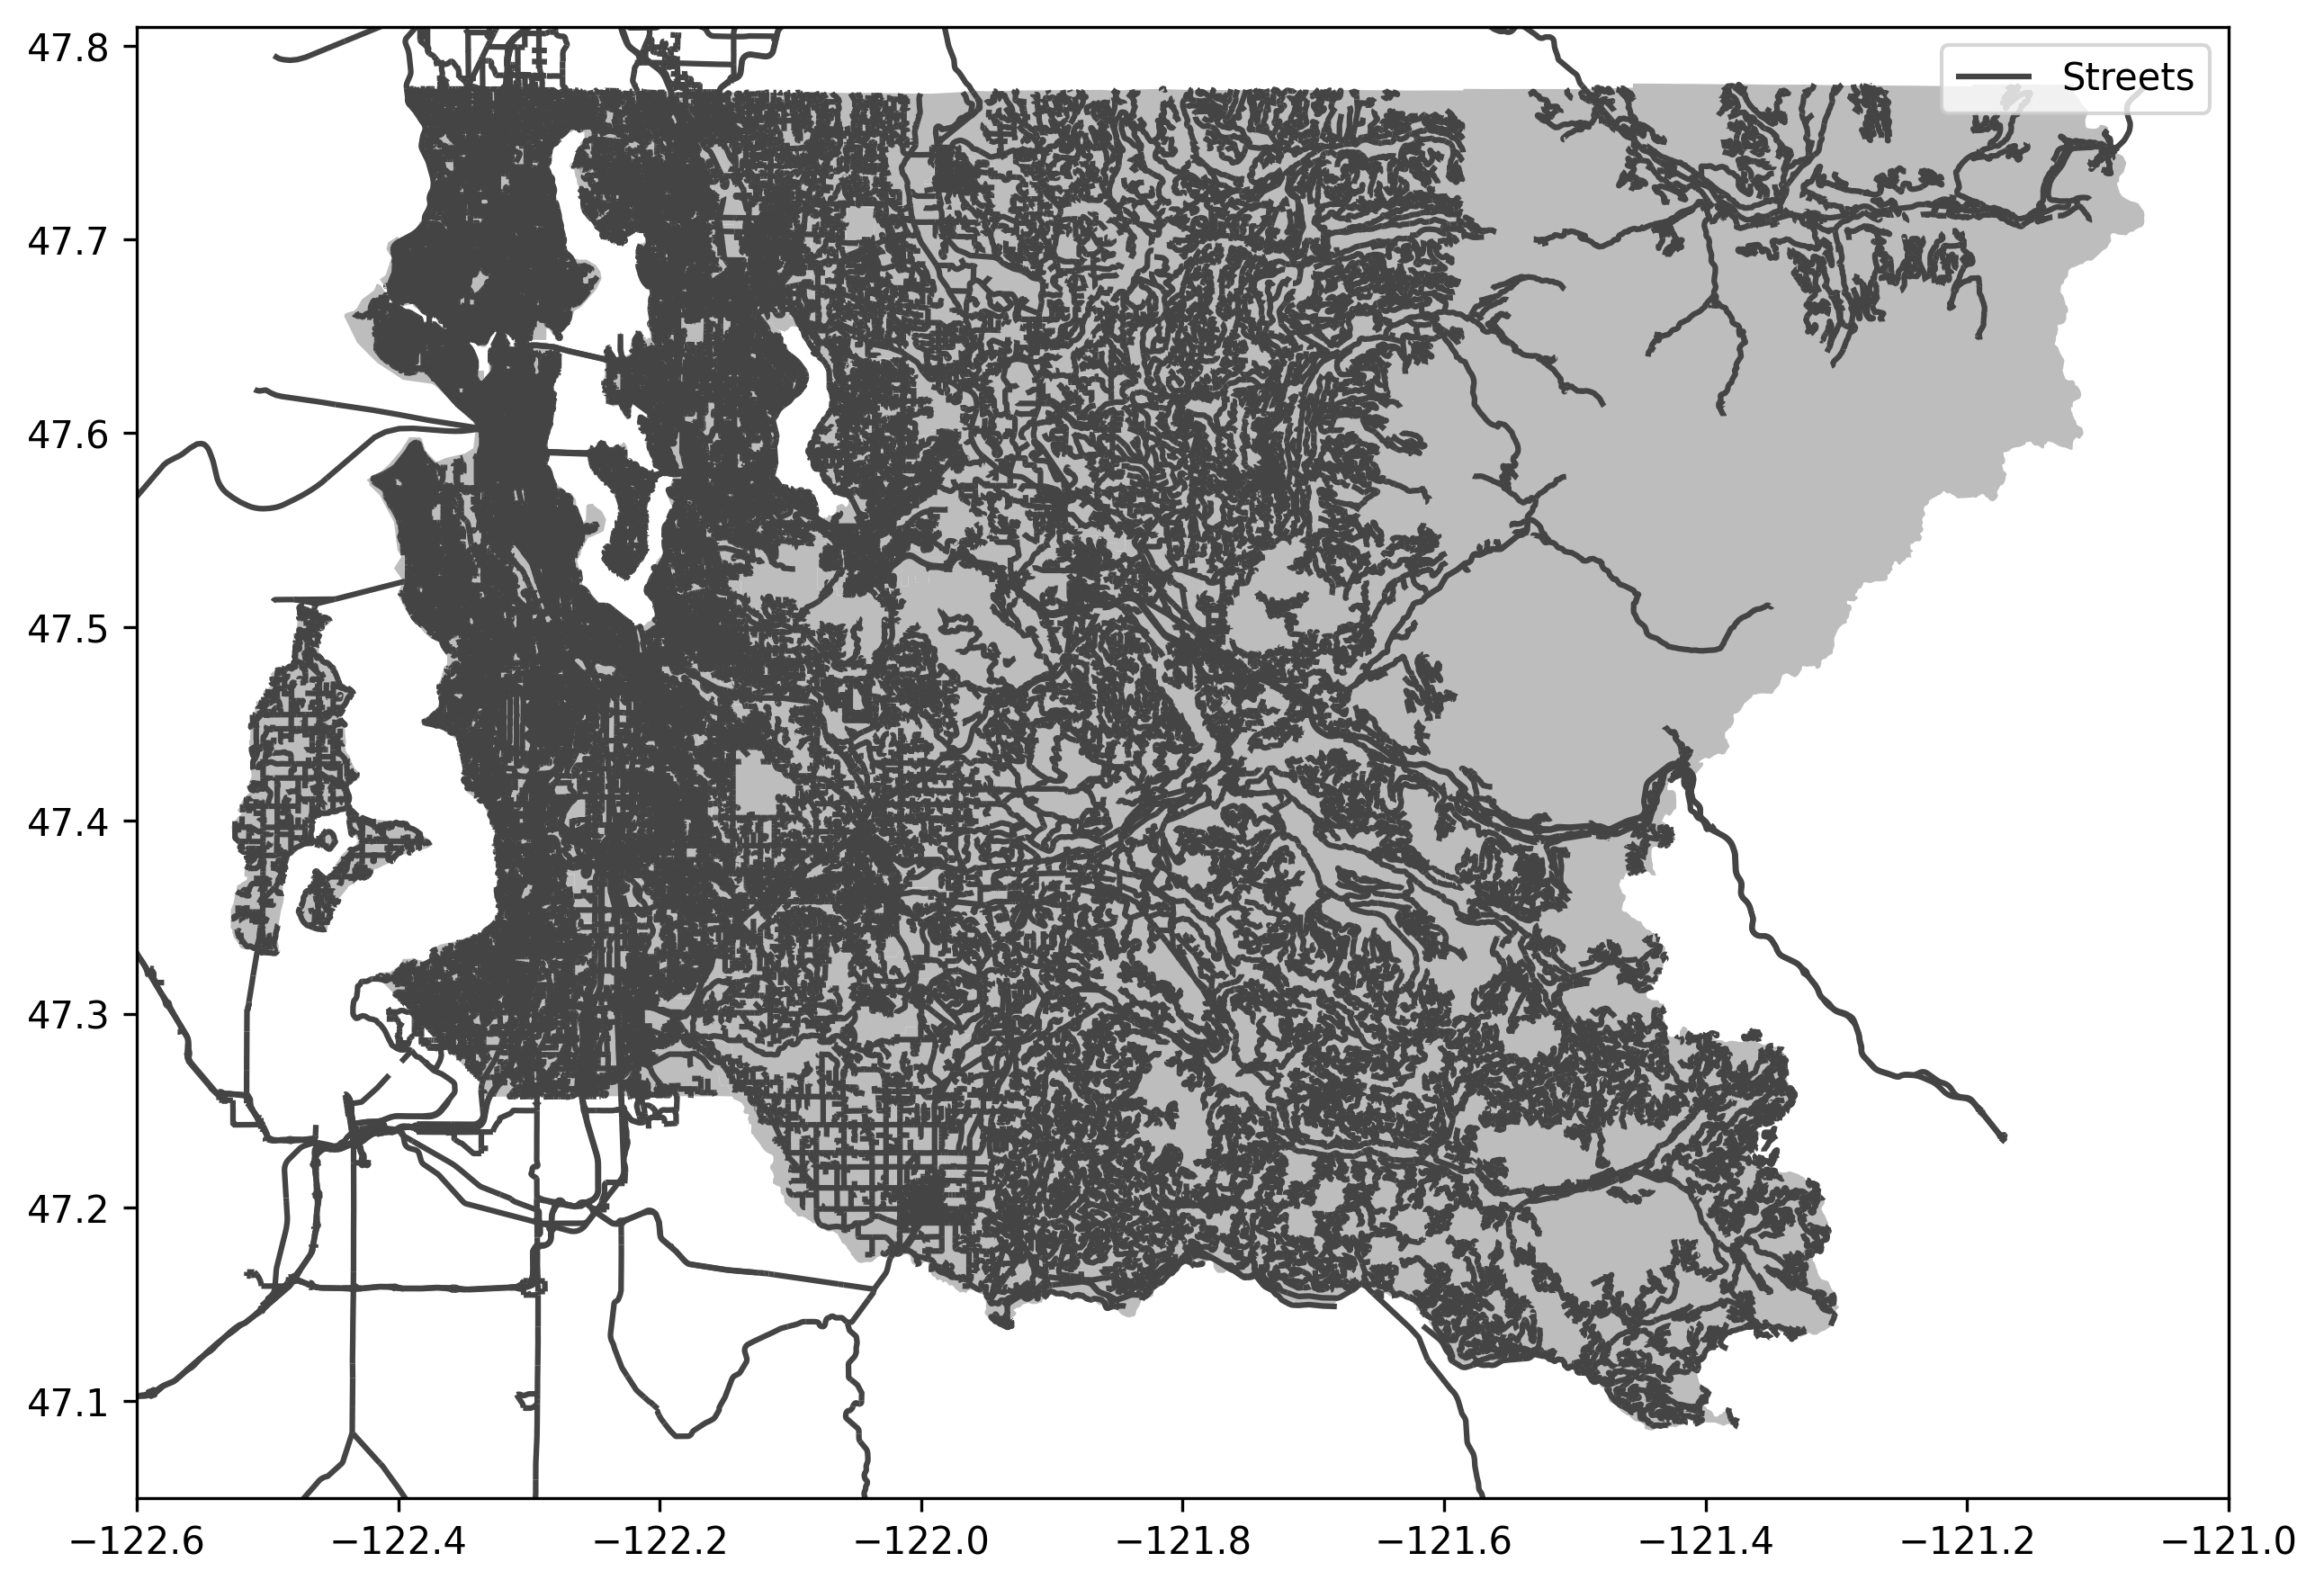

In [5]:
# Load and plot all street data.
kc_lim = pio.read_dataframe(route_data_dir +"Seattle_Streets/KCM_Streets.shp")
fig, ax = blank_kc_canvas()
kc_lim.plot(ax=ax, color='#444444')
ax.legend(["Streets"])
plt.show()

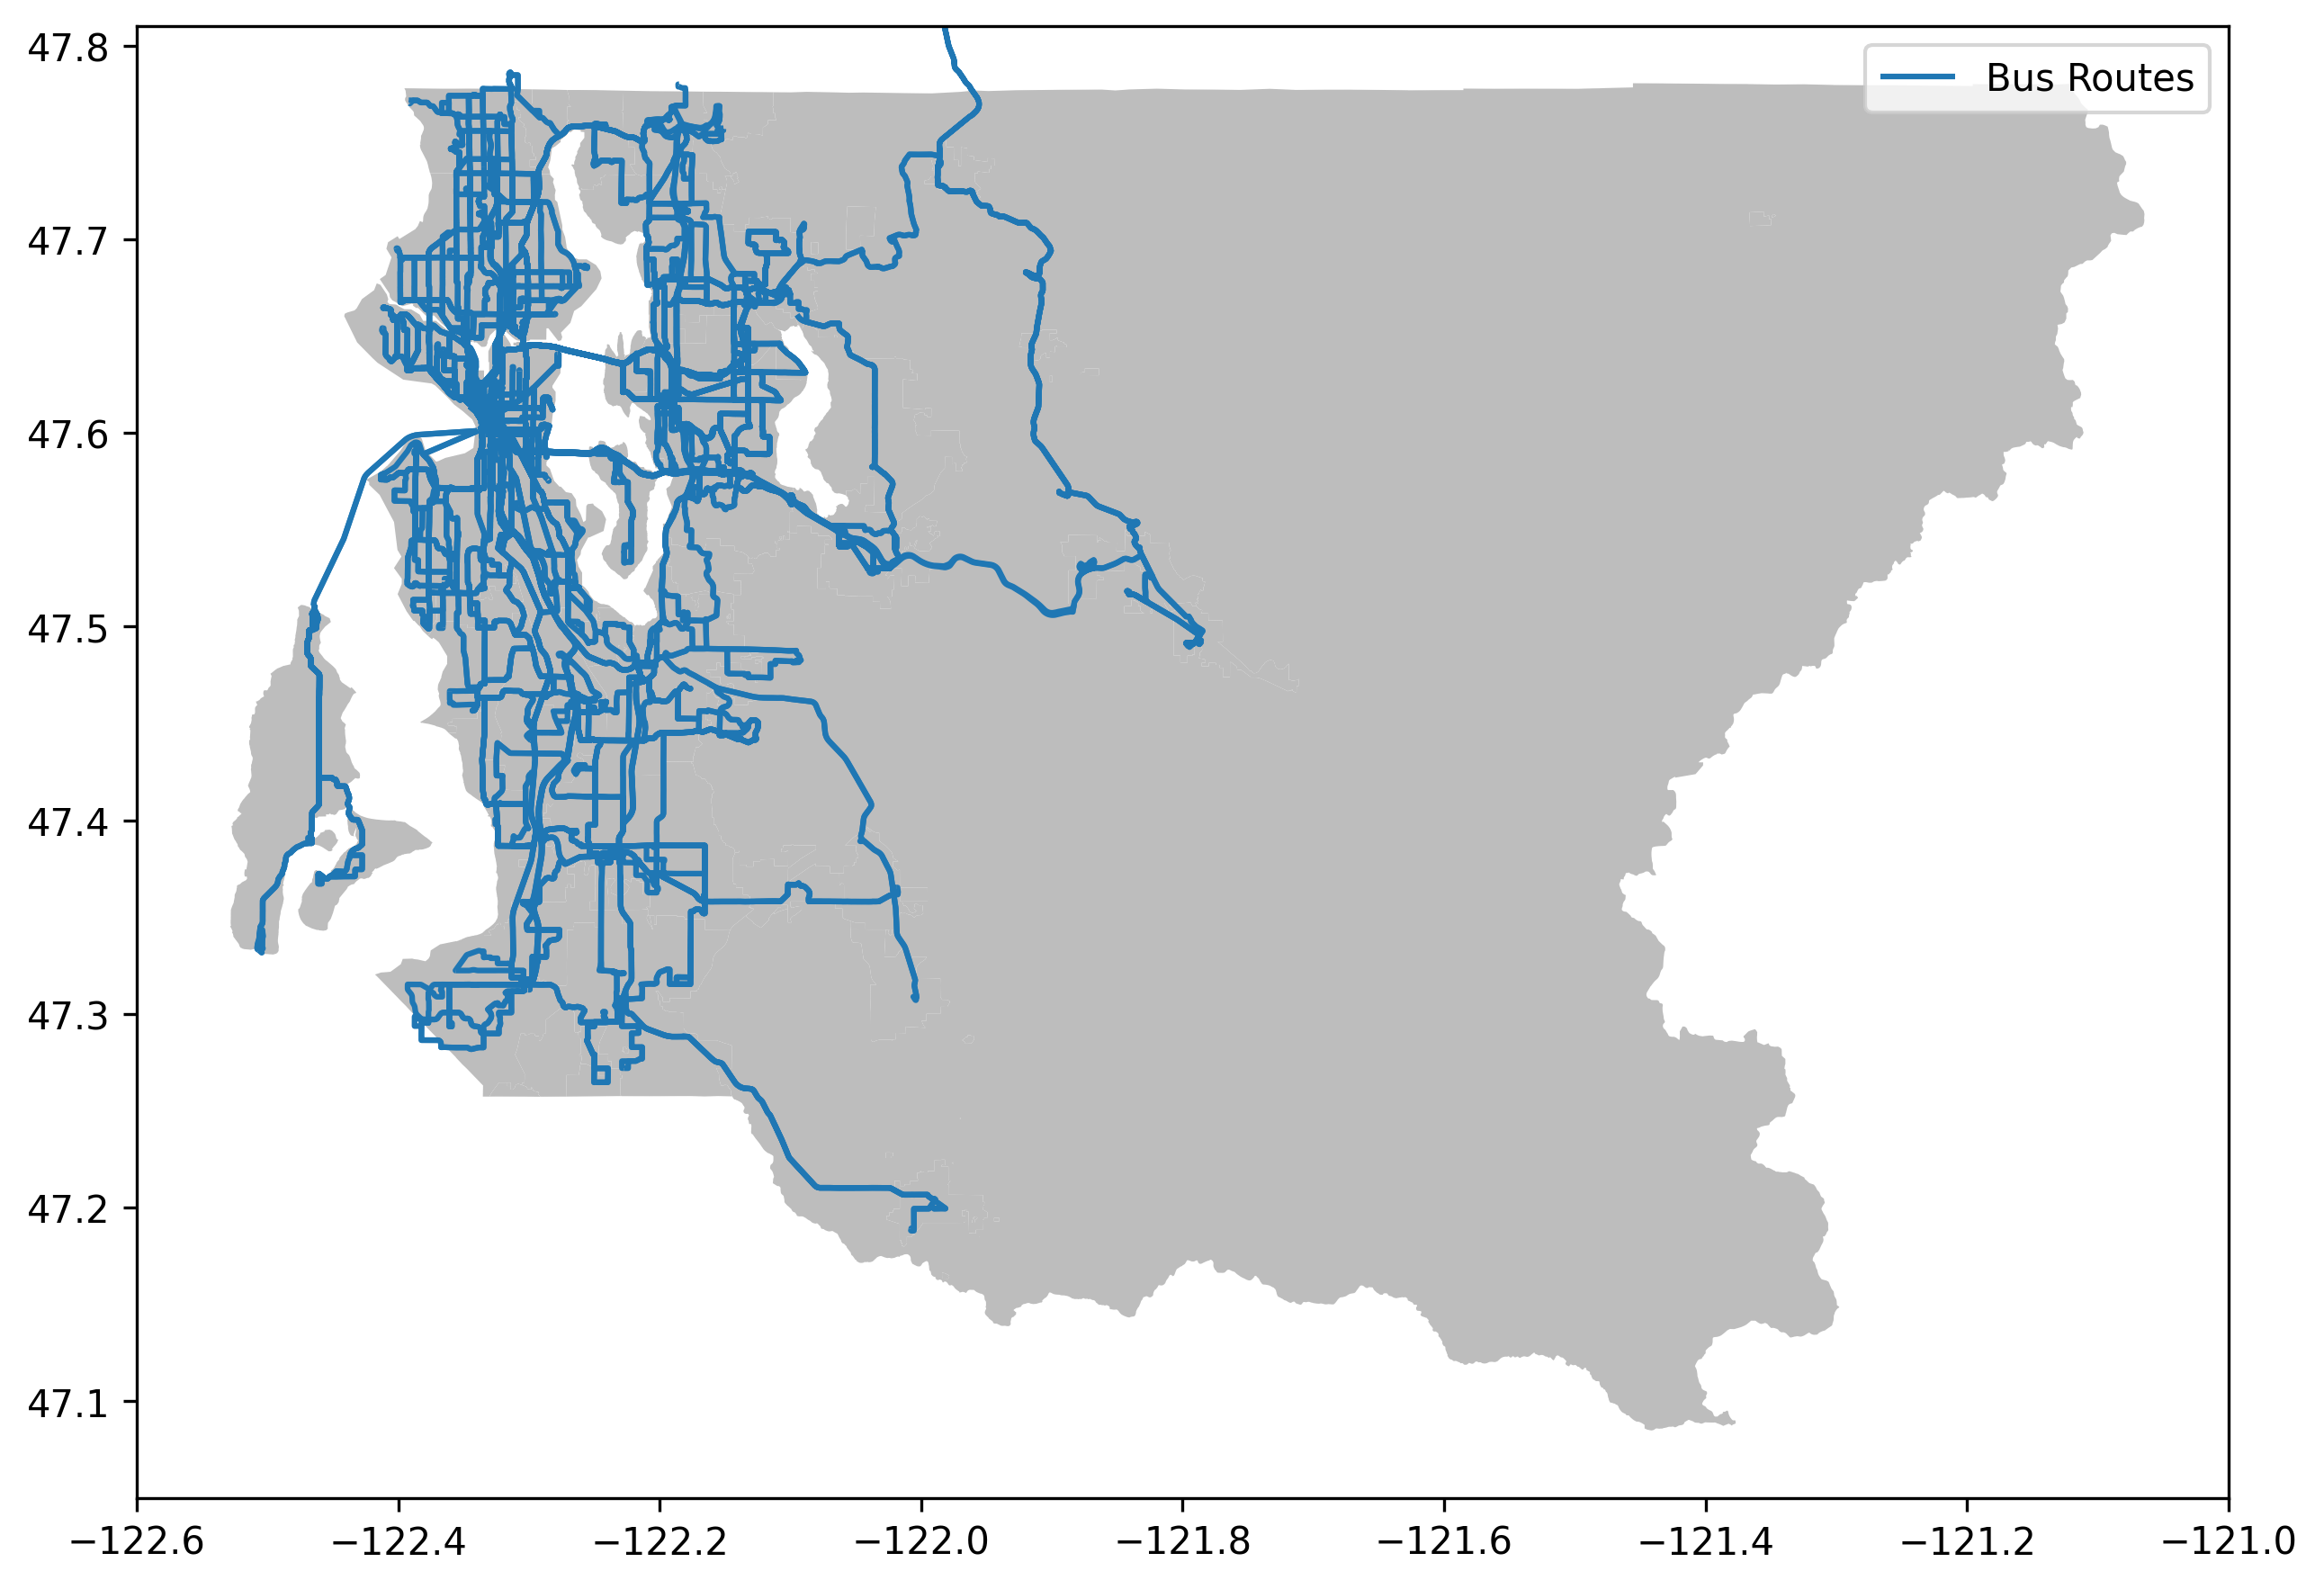

In [6]:
# Load and plot the bus routes.

shapes = pd.read_csv(route_data_dir + "shapes.txt").groupby('shape_id')

data = []
for shape in shapes.groups:
    shape_data = shapes.get_group(shape)
    geometry = shape_data.apply(lambda x: shapely.Point(x['shape_pt_lon'], x['shape_pt_lat']), axis=1)
    data.append({'shape':shape,'geometry':shapely.LineString(geometry)})
shape_routes = gpd.GeoDataFrame(data).set_crs(epsg=4326)

fig, ax = blank_kc_canvas()
shape_routes.plot(ax=ax)
ax.legend(["Bus Routes"])
plt.show()

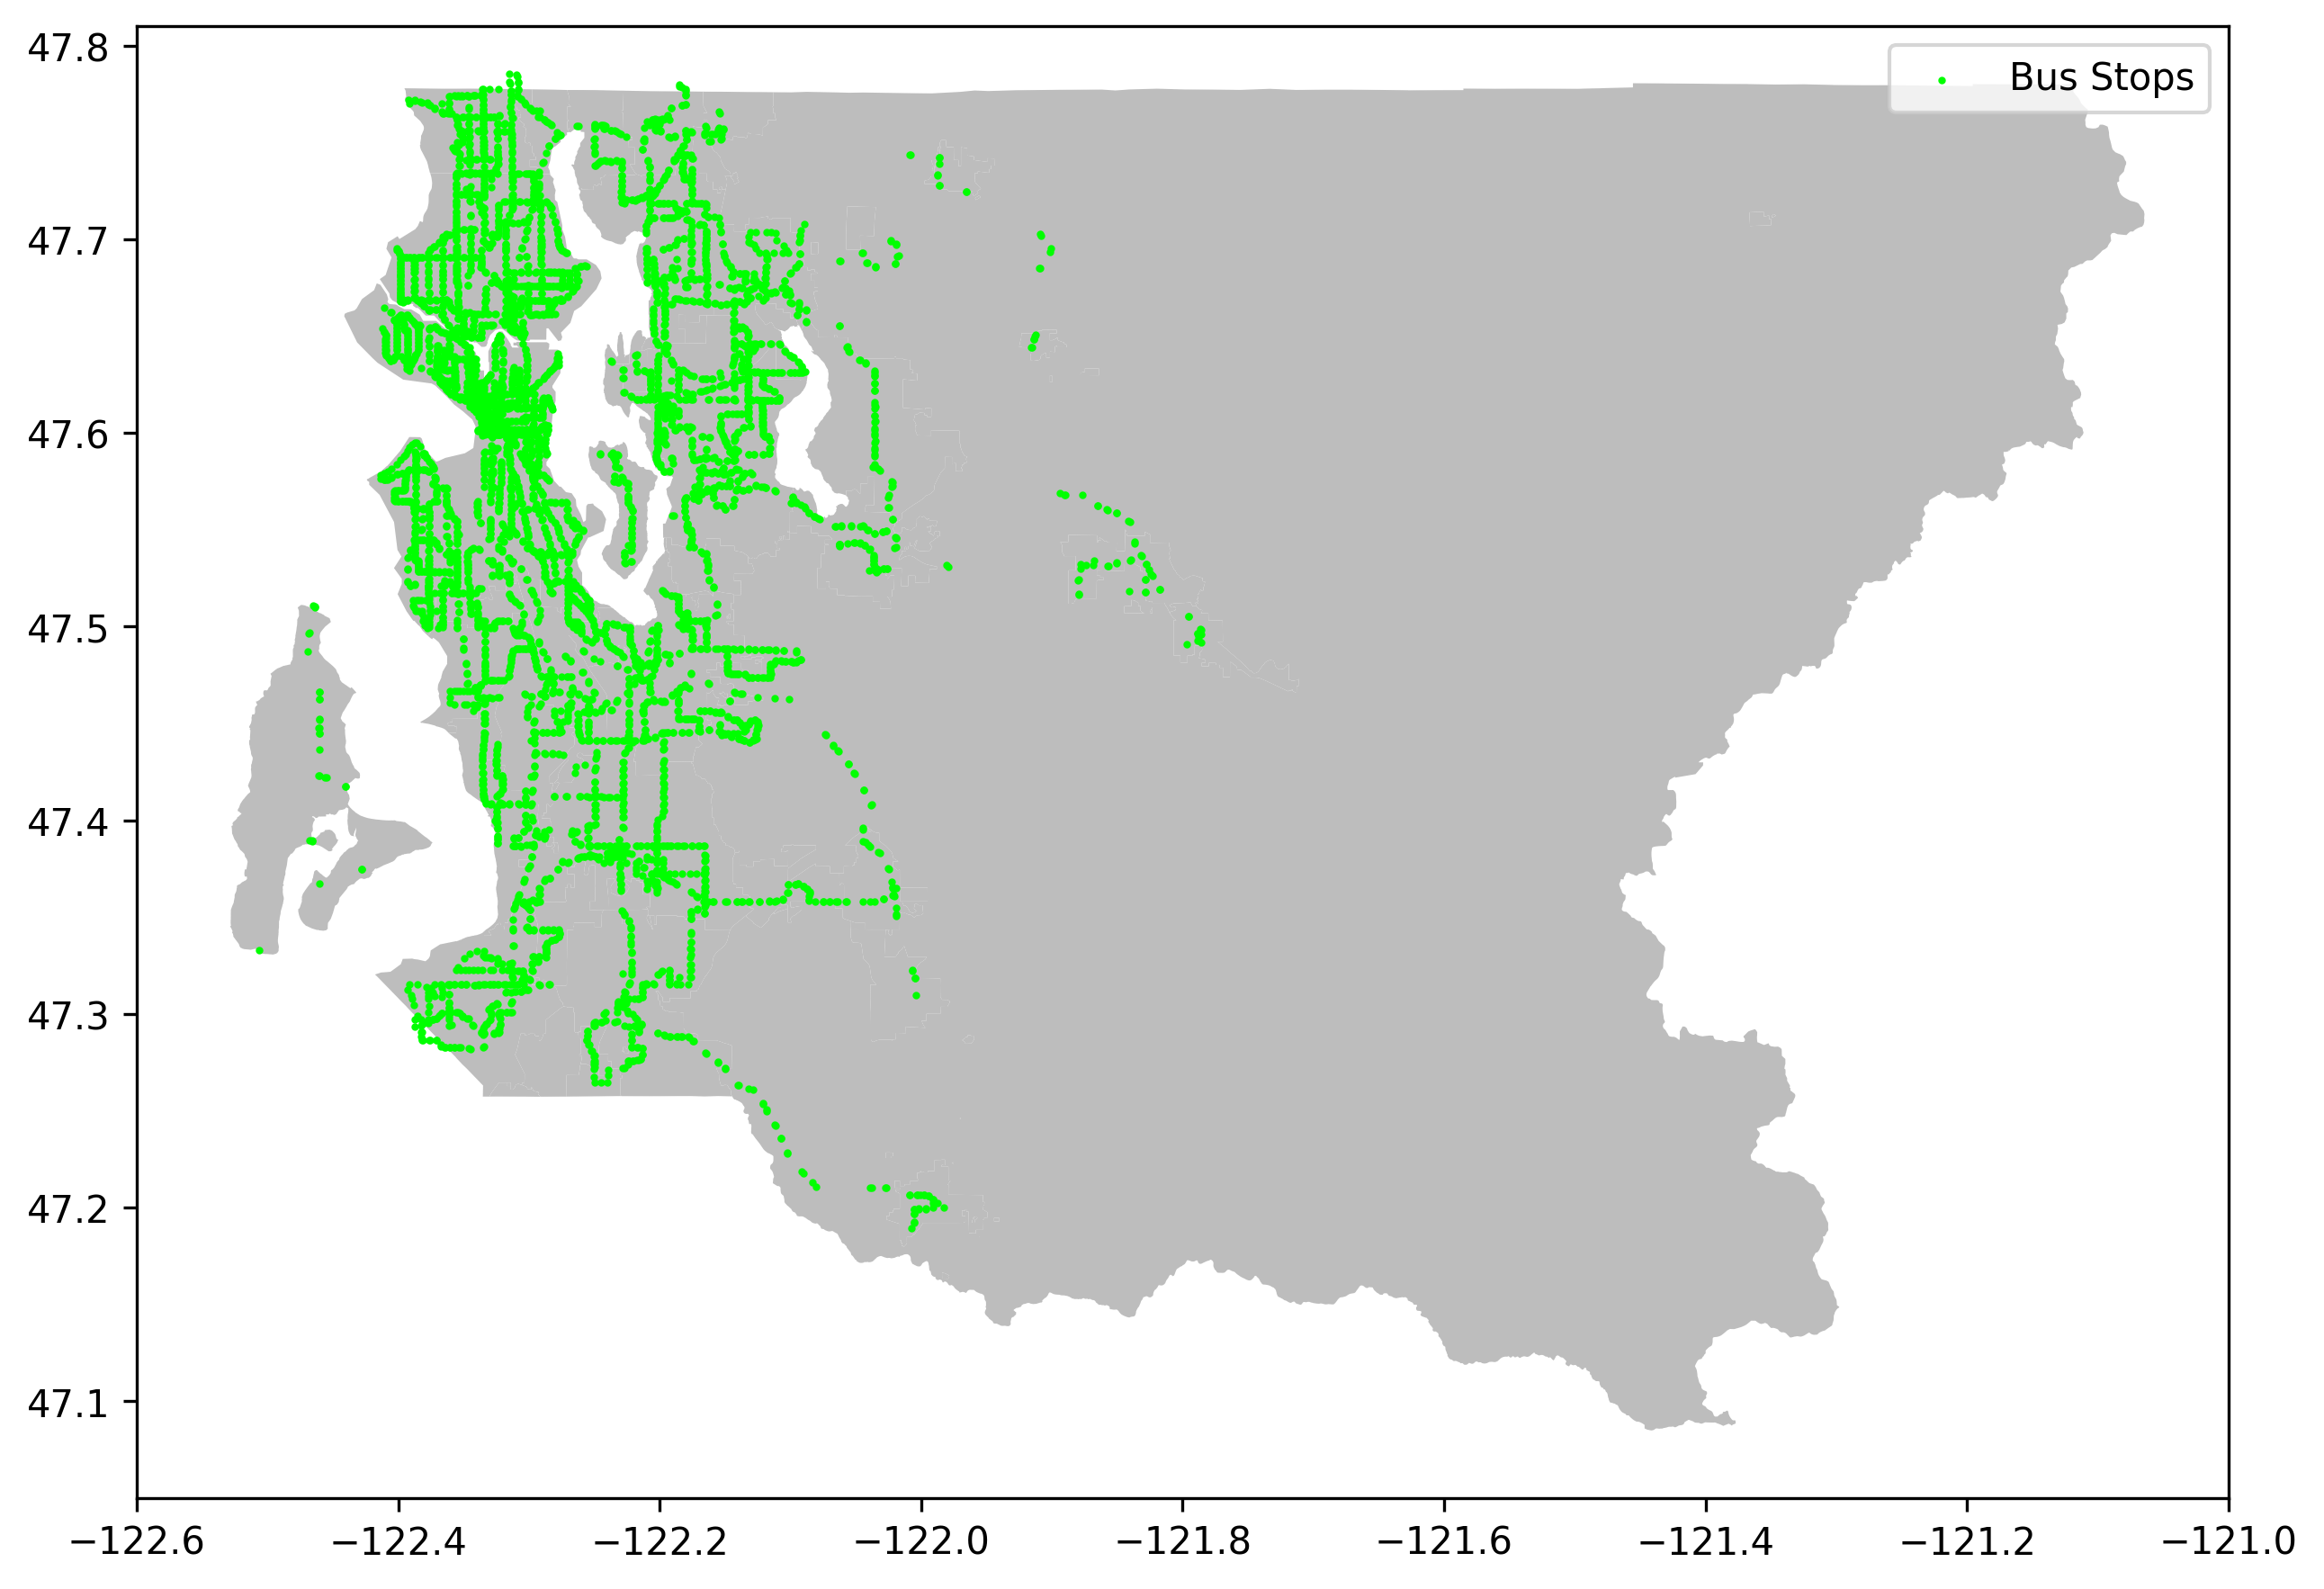

In [7]:
# Load and plot the bus stops.

bus_stops = pd.read_csv(route_data_dir + "stops.txt")
bus_stops['geometry']=bus_stops.apply(lambda x: shapely.Point(x['stop_lon'],x['stop_lat']), axis=1)
bus_stops = gpd.GeoDataFrame(bus_stops.filter(['stop_id','geometry'])).set_crs(epsg=4326)

fig, ax = blank_kc_canvas()
bus_stops.plot(ax=ax, color="lime", zorder = 10, markersize=1)
ax.legend(["Bus Stops"])
plt.show()

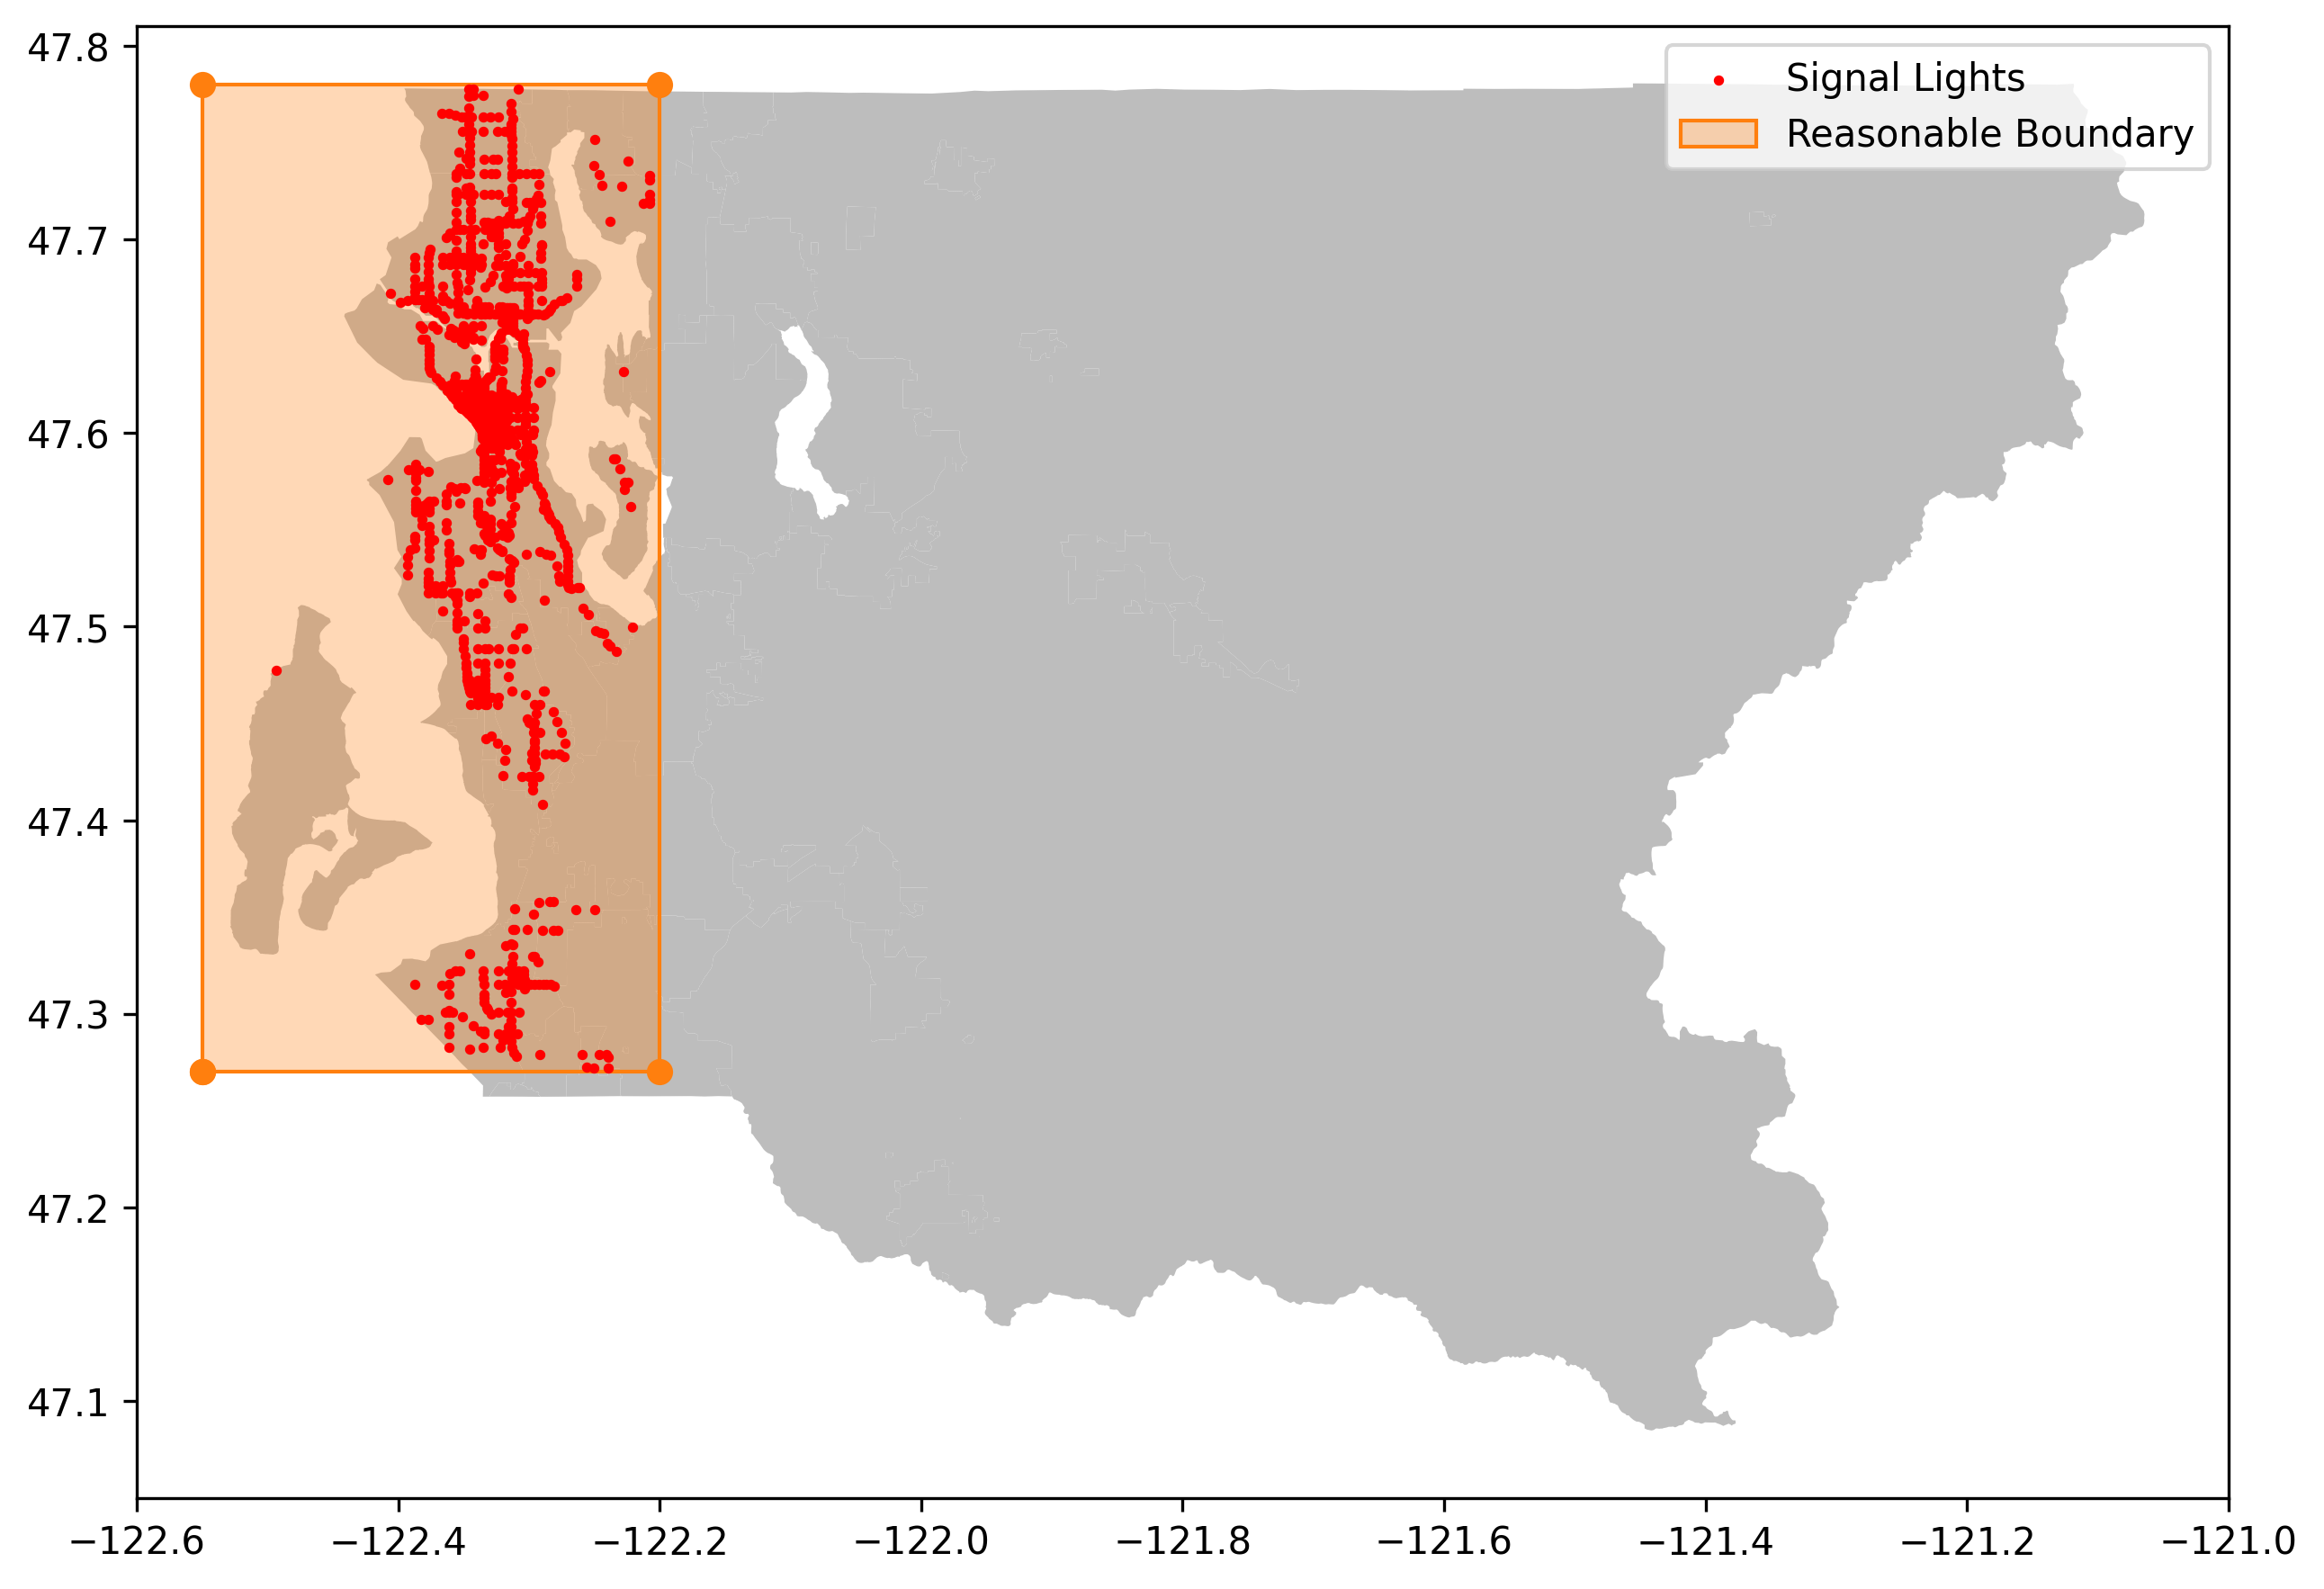

In [8]:
# Demonstrate the bounds fit the data decently enough, then plot
corners = shapely.LineString([(-122.55,47.78),(-122.2,47.27)])
bounds = gt.get_bounding_box(corners)
fig, ax = blank_kc_canvas()
bound_signals = bind_geodata(signals, bounds)
bound_signals.to_file(route_data_dir+"Signals/bound_KCM_signals.shp", driver='ESRI Shapefile')
bound_signals.plot(ax=ax, c='red',markersize=3, zorder=5)
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Signal Lights","Reasonable Boundary"])
plt.show()

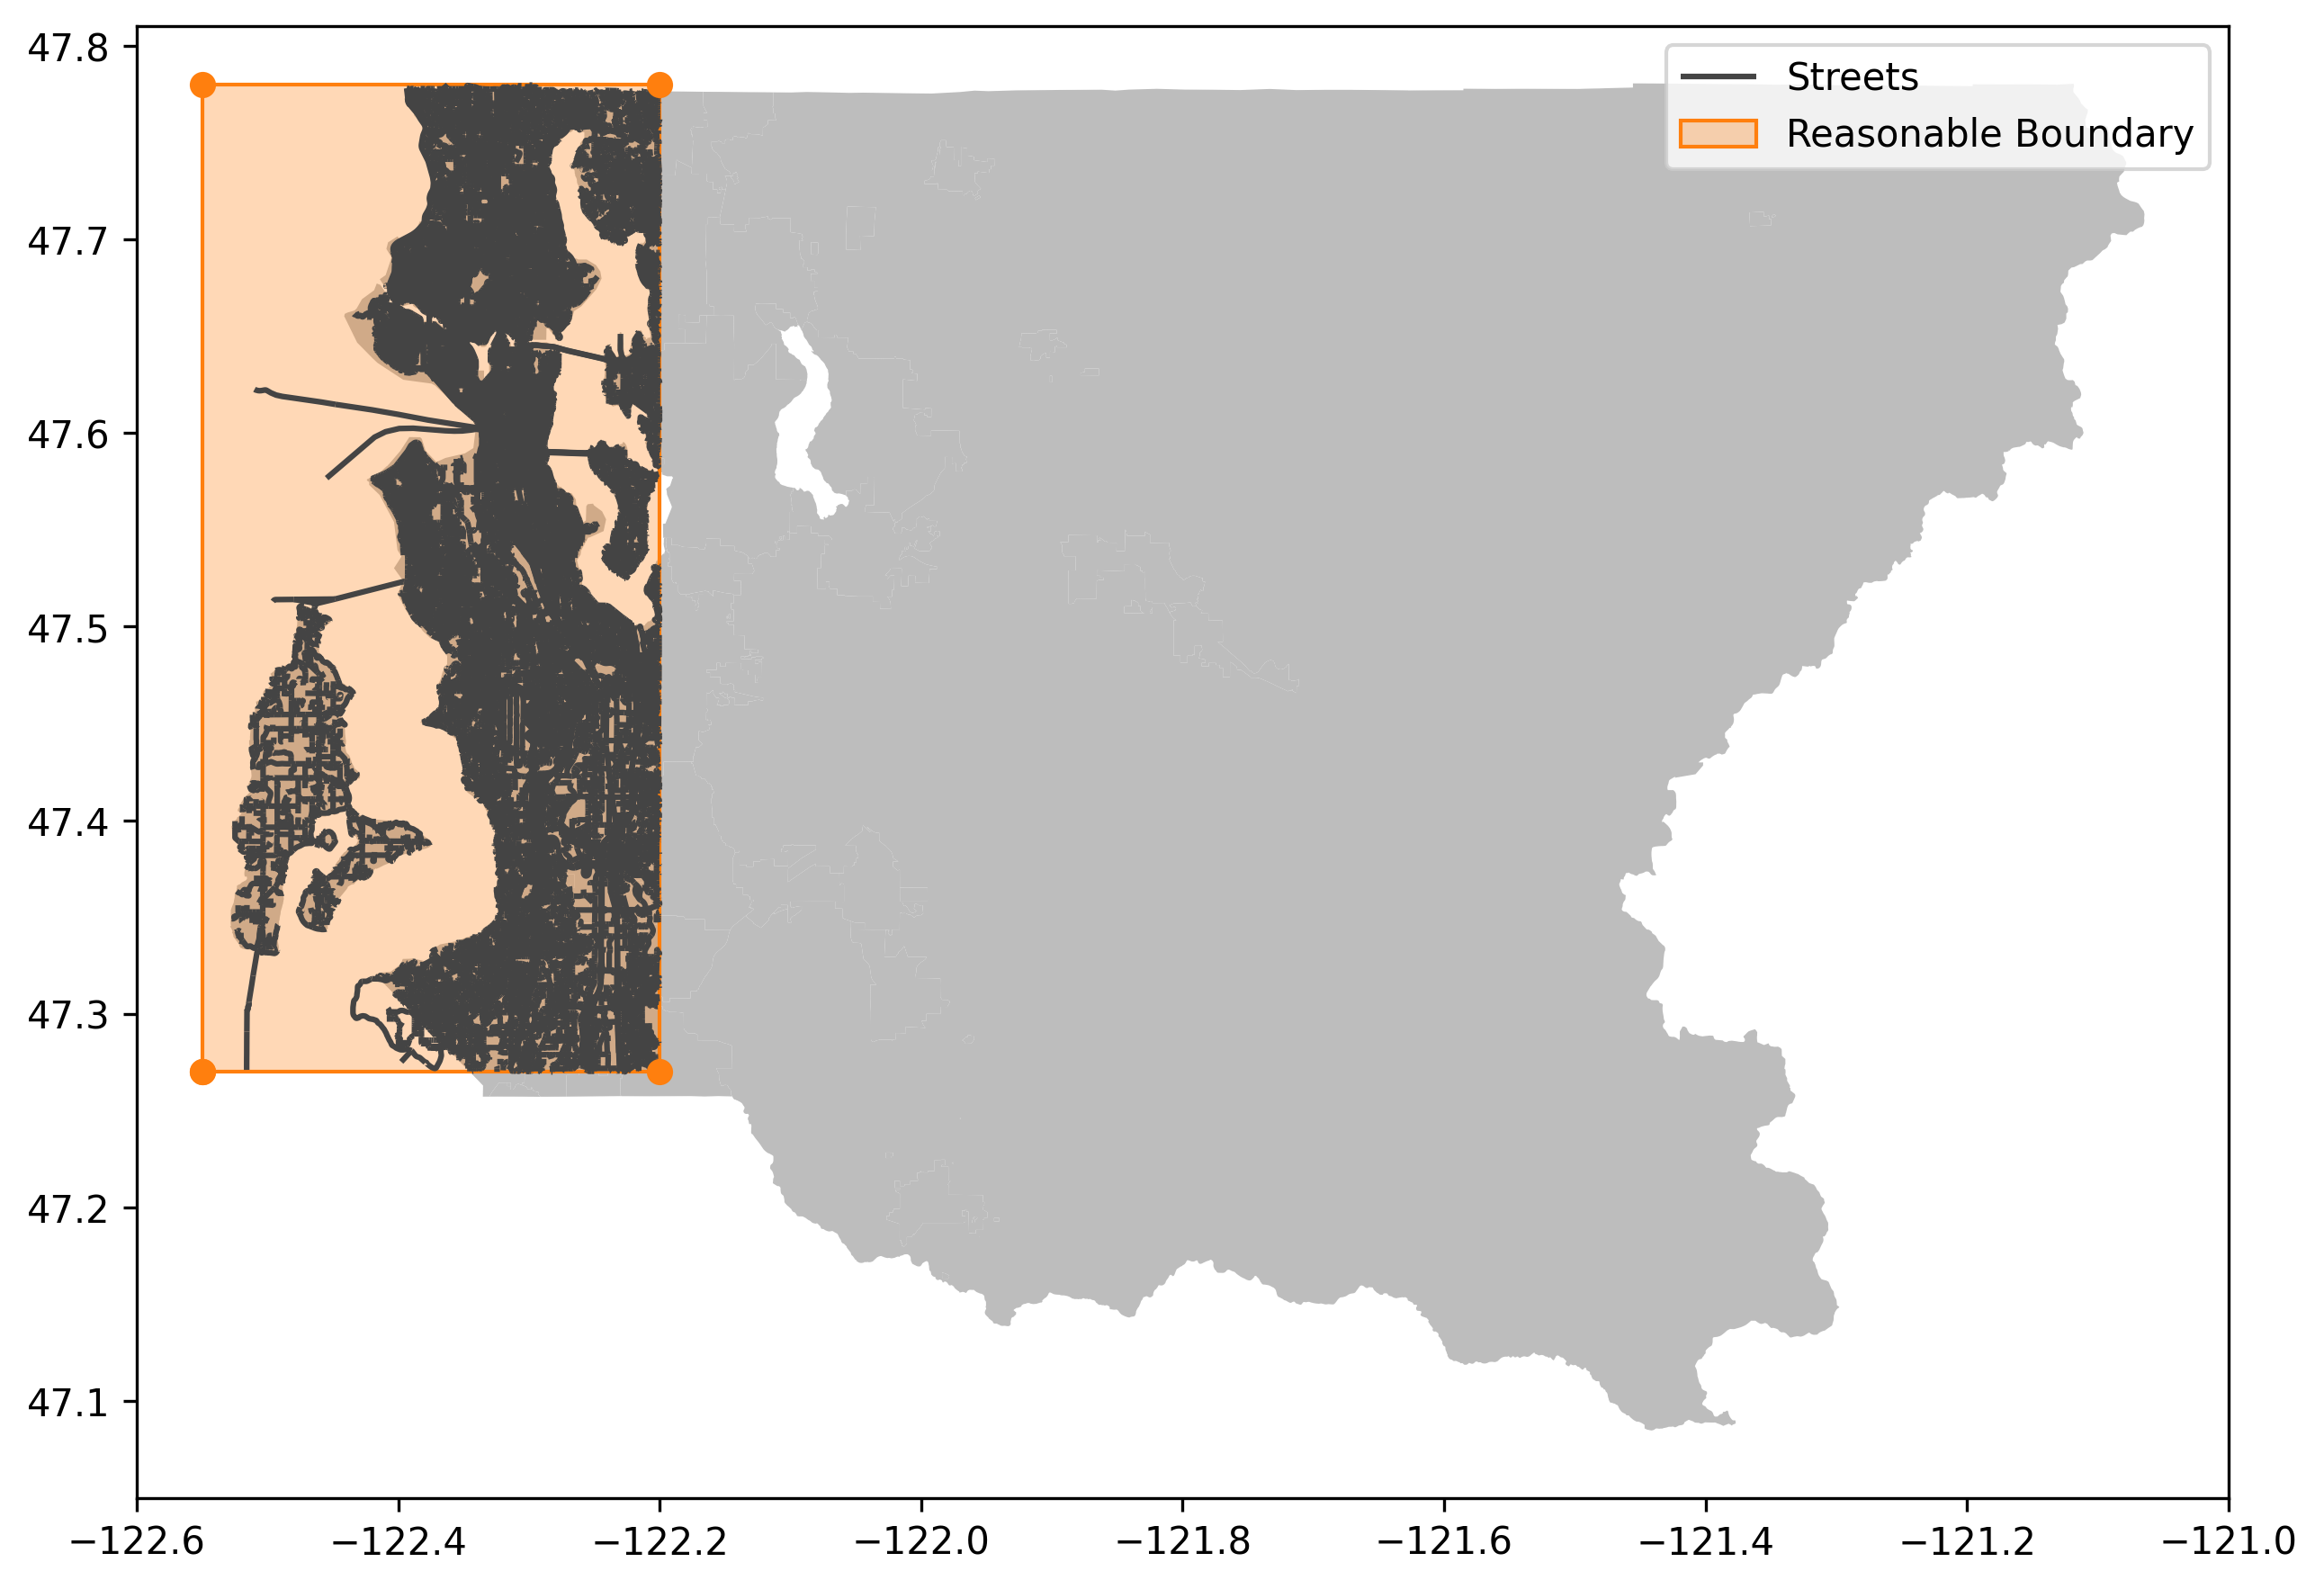

In [9]:
# re-plot with bounds
fig, ax = blank_kc_canvas()
bound_kc_lim = bind_geodata(kc_lim, bounds, how='contains')
bound_kc_lim = bound_kc_lim.filter(['SPEED_LIM', "geometry"])
bound_kc_lim.to_file(route_data_dir+"Seattle_Streets/bound_KCM_Streets.shp", driver='ESRI Shapefile')
bound_kc_lim.plot(ax=ax, color='#444444')
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Streets","Reasonable Boundary"])
plt.show()

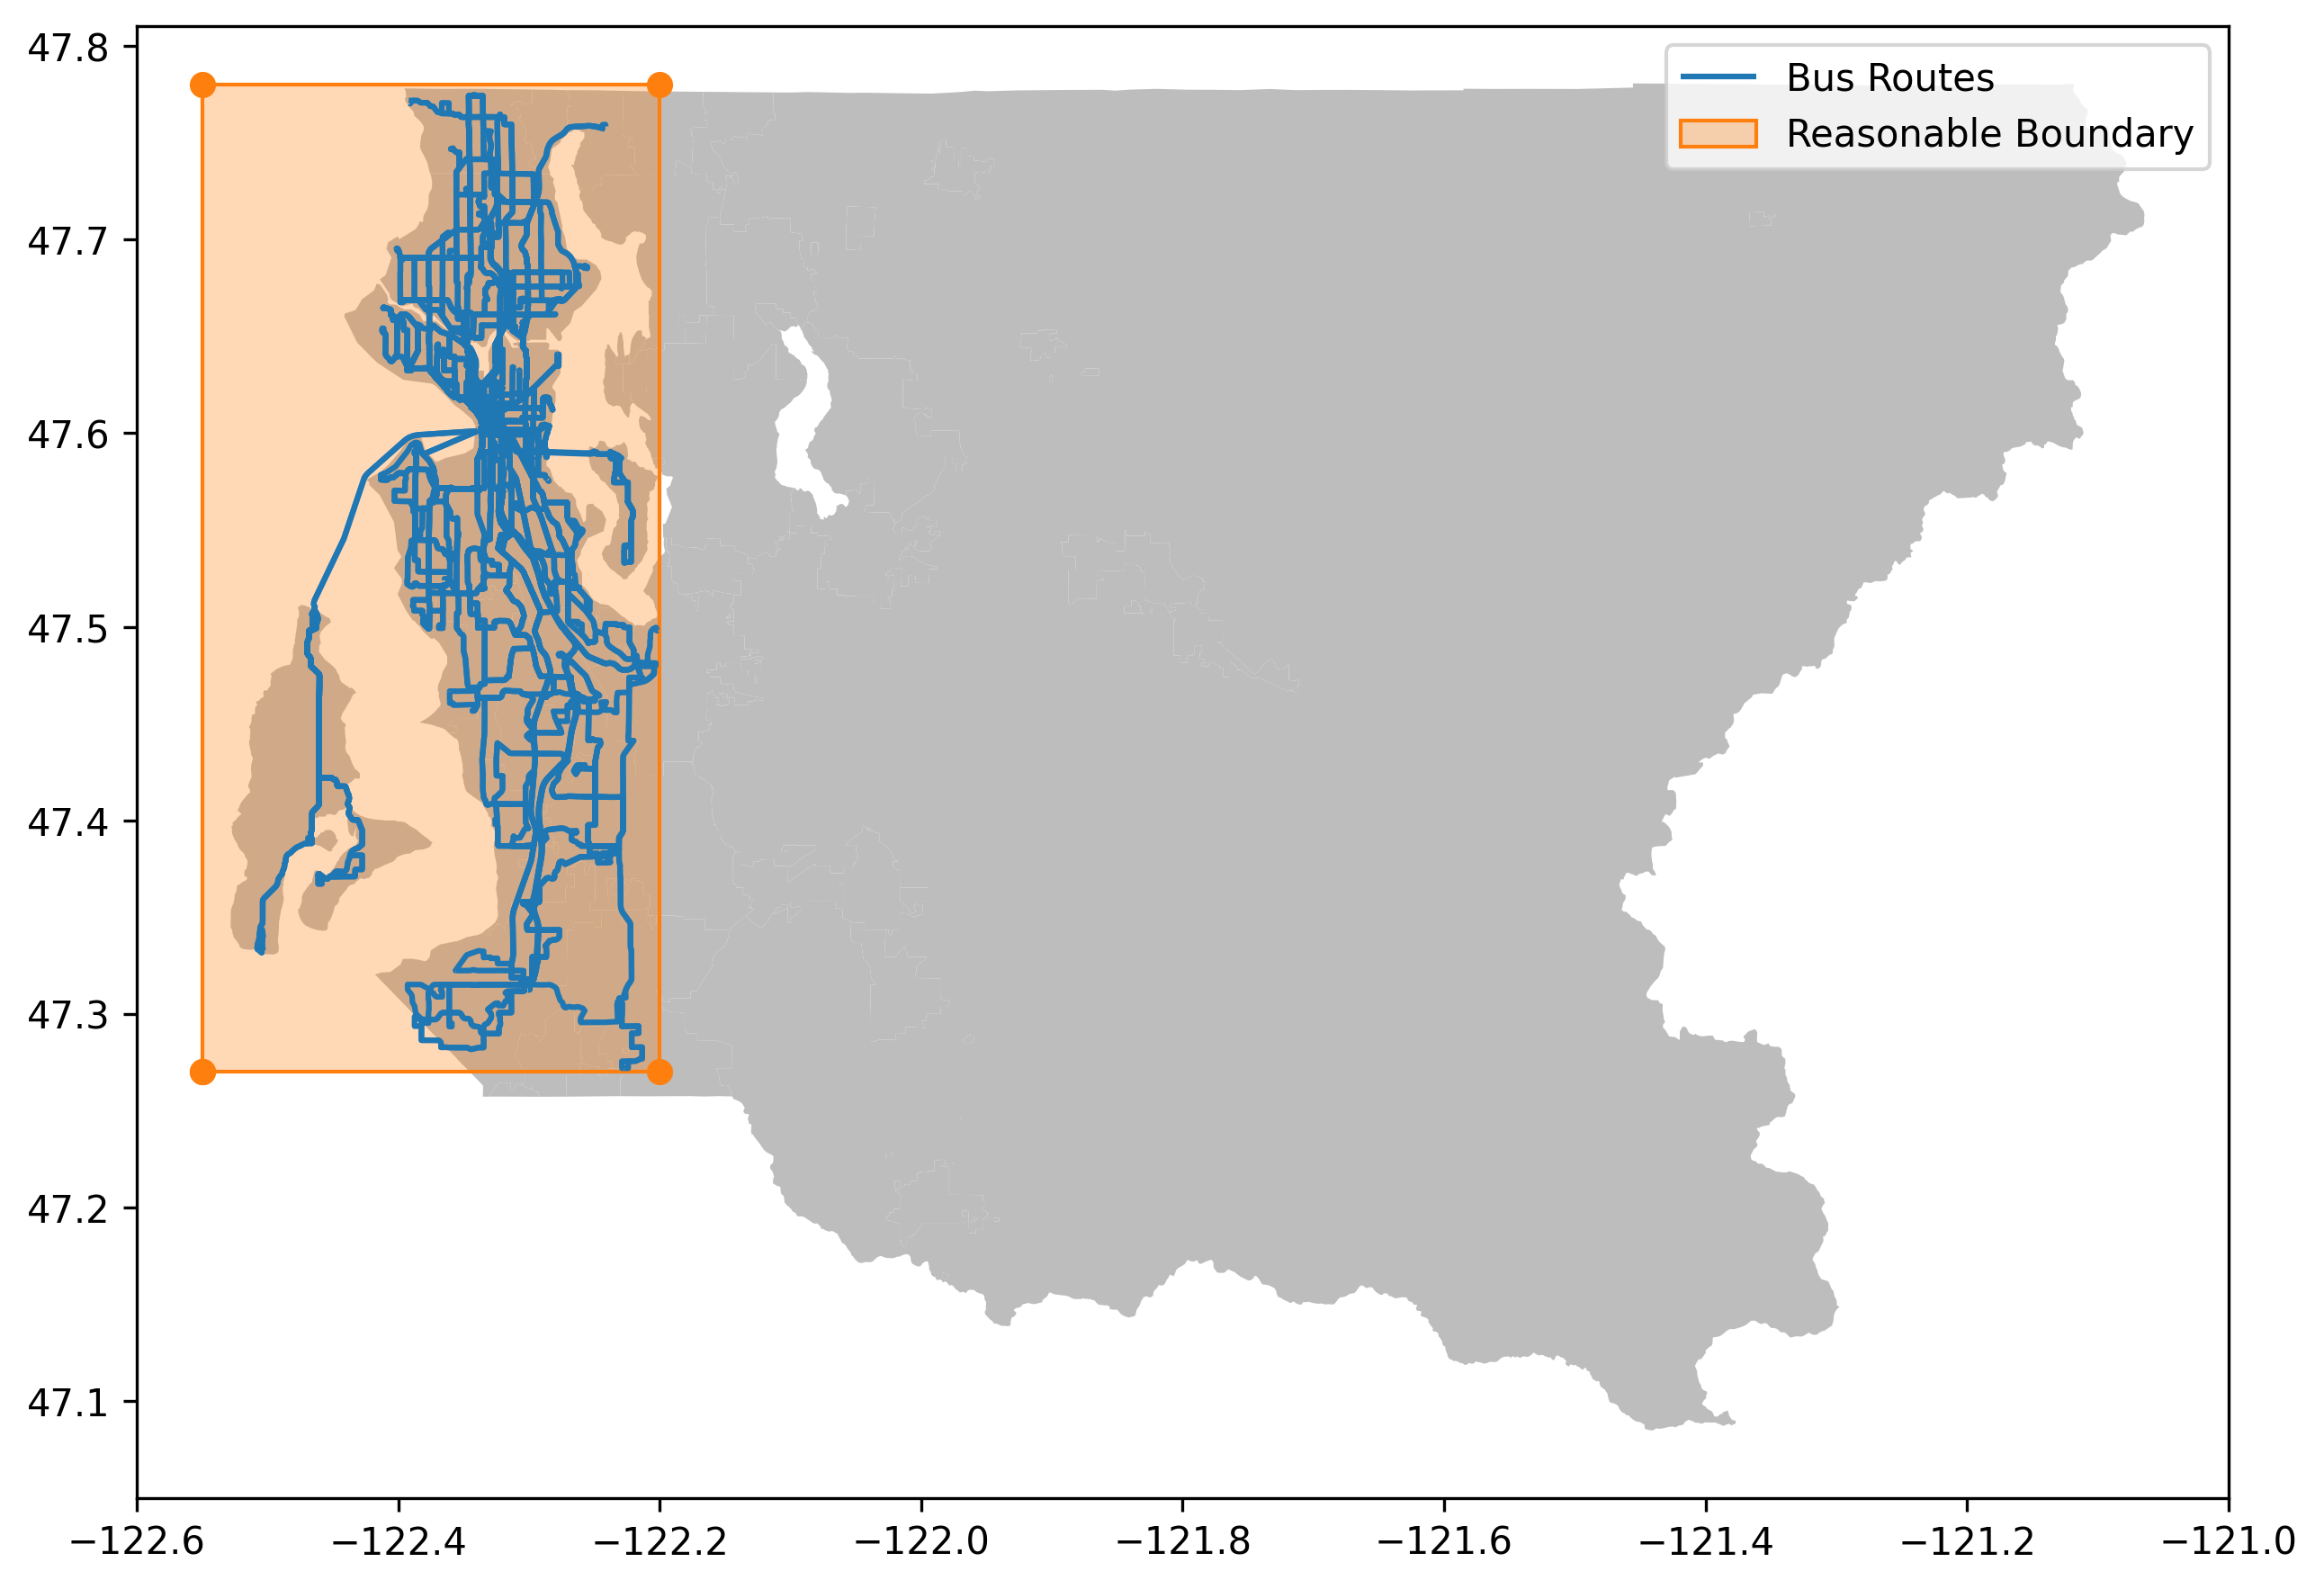

In [10]:
# re plot the routes with the bounds.
fig, ax = blank_kc_canvas()
bound_shape_routes = bind_geodata(shape_routes, bounds, how='contains')
bound_shape_routes.plot(ax=ax)
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Bus Routes","Reasonable Boundary"])
plt.show()

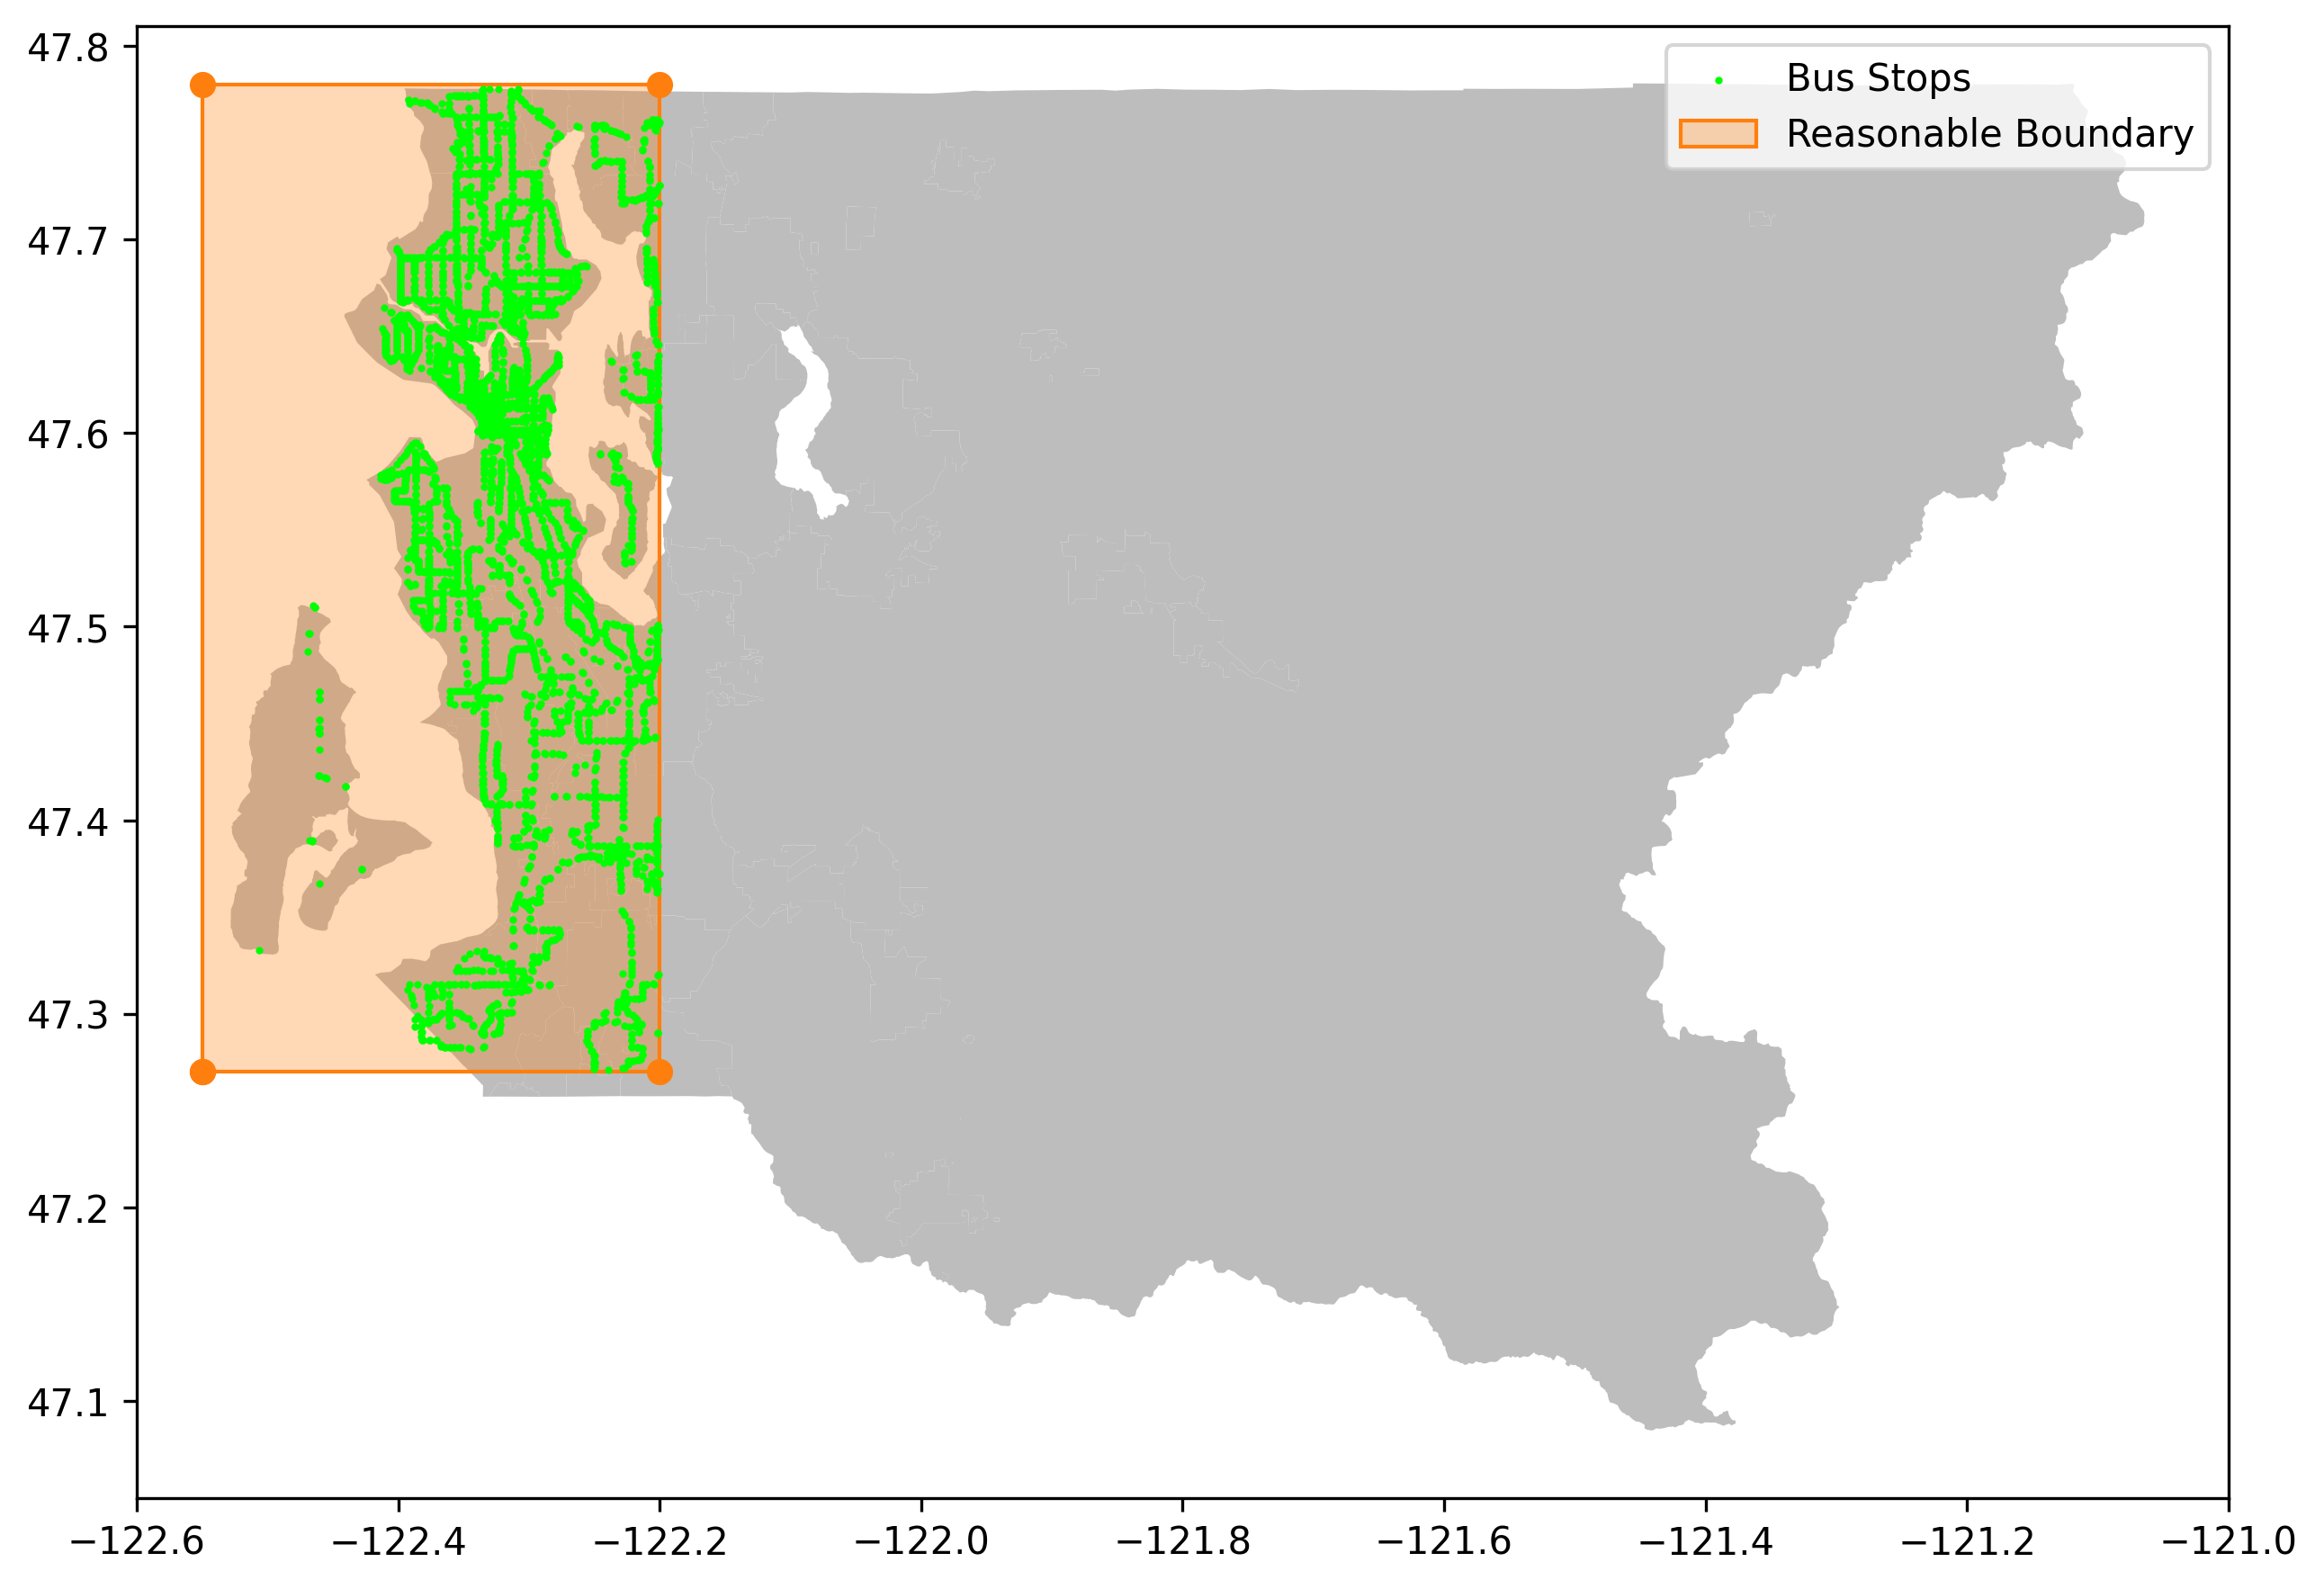

In [11]:
# Re-plot the routes with bounds
fig, ax = blank_kc_canvas()
bound_bus_stops = bind_geodata(bus_stops, bounds)
bound_bus_stops.plot(ax=ax, color="lime", zorder = 10, markersize=1)
shapeplt.plot_polygon(bounds, ax=ax, color='tab:orange')
ax.legend(["Bus Stops", "Reasonable Boundary"])
plt.show()

In [12]:
# extract ridership data for full factorial combinations
formatted_rider_data = kqt.calculate_expected_ridership(ridership_data_path)

# And also get all the routes with ridership data while converting the values to string for inter-operability.
route_options = list(pd.Series(formatted_rider_data['rt'].unique()).apply(str))

In [13]:
# Get all the route ids based on the routes in the bounds
route_ids = []
for option in route_options:
    try:
        route_id = kqt.query_route_id(option, route_data_dir + "routes.txt")
        shapes = kqt.query_possible_shapes(route_id, route_data_dir+"trips.txt")
        route_ids.append({"shortname":option,"route_id":route_id, "shape":shapes, "direction":[0,1]})
        
    except: 
        print("{} not found.".format(option))
route_ids = pd.DataFrame(route_ids)

15 not found.
18 not found.
19 not found.
26 not found.
29 not found.
37 not found.
41 not found.
47 not found.
55 not found.
63 not found.
64 not found.
71 not found.
73 not found.
74 not found.
76 not found.
77 not found.
78 not found.
114 not found.
116 not found.
120 not found.
121 not found.
122 not found.
123 not found.
143 not found.
154 not found.
157 not found.
158 not found.
159 not found.
164 not found.
166 not found.
167 not found.
169 not found.
178 not found.
179 not found.
180 not found.
186 not found.
190 not found.
192 not found.
197 not found.
200 not found.
201 not found.
214 not found.
216 not found.
217 not found.
219 not found.
232 not found.
234 not found.
235 not found.
236 not found.
237 not found.
238 not found.
243 not found.
244 not found.
248 not found.
252 not found.
268 not found.
277 not found.
301 not found.
304 not found.
308 not found.
309 not found.
312 not found.
316 not found.
330 not found.
342 not found.
347 not found.
355 not found.
373 not foun

In [14]:
importlib.reload(op)
# make unique rows per shape
route_shapes = route_ids.explode("shape").reset_index(drop=True)

# get the shapes within the bounds
bound_route_options = route_shapes[route_shapes['shape'].isin(bound_shape_routes['shape'].unique())].reset_index(drop=True)
# Create rows for each option
bound_route_options = bound_route_options.explode("direction")

# Load the paths up.
bound_route_options['path'] = bound_route_options.apply(lambda x: route_savepath + 'rt{}_sh{}_d{}.json'.format(x.shortname, x['shape'], x['direction']),axis=1)
bound_route_options = bound_route_options.reset_index(drop=True)

# Load the ridership data
formatted_rider_data = kqt.calculate_expected_ridership(ridership_data_path)
formatted_rider_data['io']=formatted_rider_data['io'].apply(lambda x: 0 if x=='I' else 1)

# Get period ridership for each route option
bound_route_options['rider_dict'] = bound_route_options.apply(lambda x: kqt.get_ridership(x.shortname, x.direction, formatted_rider_data), axis=1)

# Read the bus live data tracking info TODO MAKE VARIABLE
timelog= pd.read_csv('bus_time_tracking2.csv')

# load up the individual bus types
timelog['btype'] = timelog[timelog.apply(lambda x: len(x['bus']), axis=1) == 4].apply(lambda x: kqt.bus_type_finder(int(x.bus)), axis=1)

# Pass the bus types to each route instance
bound_route_options['bus'] = bound_route_options.apply(lambda x: timelog.groupby('rt').get_group(x['route_id'])['btype'].unique() if x['route_id'] in timelog.groupby('rt').groups else ["NA"], axis=1)

# create individual instances for each bus type a route can take
bound_route_options = bound_route_options.explode('bus').reset_index(drop=True)

# Remove any instances with No bus model information
prepped_routes = bound_route_options[bound_route_options['bus'].apply(lambda x: x != "NA")].reset_index(drop=True)

# Conver busses to bus object paths
prepped_routes['bus'] = prepped_routes['bus'].apply(lambda x: bus_save_path + '{}.txt'.format(x))

# Set up the minimum and maximum for ridership
prepped_routes['ridership_min_max'] = prepped_routes['rider_dict'].apply(lambda x: {k: v for d in x for k, v in d.items()}.values())
prepped_routes['ridership_min_max'] = prepped_routes['ridership_min_max'].apply(lambda x: (min(x), max(x)))

prepped_routes = prepped_routes.reset_index(drop=True)


In [15]:
prepped_routes['shortname'].unique()

array(['1', '2', '3', '4', '5', '7', '8', '10', '11', '12', '13', '14',
       '21', '22', '24', '27', '28', '31', '32', '33', '36', '40', '43',
       '44', '45', '48', '49', '50', '60', '62', '65', '67', '70', '75',
       '101', '106', '107', '118', '124', '125', '128', '131', '132',
       '150', '153', '156', '181', '182', '183', '187', '345', '346',
       '348', '372'], dtype=object)

In [16]:
# render the routes!!!!
importlib.reload(gt)
importlib.reload(kqt)
kqt.batch_render_kc_routes(prepped_routes['shortname'].unique(),
                           route_data_dir,
                           dsm_raster_path,
                           './KC_Example_Data/Saved_Routes/',
                           batch_size=14, verbose=True)


[10:48:59.140895 -- KC_Query_Tools.batch_render_kc_routes()] Filename ./KC_Example_Data/Saved_Routes/rt1_sh11001004_d0.json exists already. Skipping...                  
[10:48:59.180317 -- KC_Query_Tools.batch_render_kc_routes()] Filename ./KC_Example_Data/Saved_Routes/rt1_sh11001004_d1.json exists already. Skipping...                  
[10:48:59.184877 -- KC_Query_Tools.batch_render_kc_routes()] Filename ./KC_Example_Data/Saved_Routes/rt1_sh20001002_d0.json exists already. Skipping...                  
[10:48:59.189236 -- KC_Query_Tools.batch_render_kc_routes()] Filename ./KC_Example_Data/Saved_Routes/rt1_sh20001002_d1.json exists already. Skipping...                  
[10:48:59.193111 -- KC_Query_Tools.batch_render_kc_routes()] Filename ./KC_Example_Data/Saved_Routes/rt1_sh11001003_d0.json exists already. Skipping...                  
[10:48:59.197614 -- KC_Query_Tools.batch_render_kc_routes()] Filename ./KC_Example_Data/Saved_Routes/rt1_sh11001003_d1.json exists already. Skipping..

Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (1232,) (1344,) 


|████████████████████████████████████████| 1344/1344 [100%] in 16.7s (80.37/s) 
|████████████████████████████████████████| 1506/1506 [100%] in 17.9s (83.97/s) 
|████████████████████████████████████████| 1506/1506 [100%] in 8.2s (182.86/s) 
Failed Rendering ./KC_Example_Data/Saved_Routes/rt182_sh10182002_d0.json, Error: operands could not be broadcast together with shapes (1395,) (1506,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (1395,) (1506,) 


|████████████████████████████████████████| 1506/1506 [100%] in 6.0s (252.57/s) 
|████████████████████████████████████████| 1344/1344 [100%] in 5.9s (227.06/s) 
Failed Rendering ./KC_Example_Data/Saved_Routes/rt182_sh10182002_d1.json, Error: operands could not be broadcast together with shapes (1395,) (1506,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (1395,) (1506,) 


Failed Rendering ./KC_Example_Data/Saved_Routes/rt182_sh21182004_d1.json, Error: operands could not be broadcast together with shapes (1232,) (1344,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (1232,) (1344,) 


|████████████████████████████████████████| 2738/2738 [100%] in 1:26.3 (31.72/s) 
|████████████████████████████████████████| 2796/2796 [100%] in 1:30.2 (31.01/s) 
|████████████████████████████████████████| 2796/2796 [100%] in 1:45.9 (26.40/s) 
|████████████████████████████████████████| 2738/2738 [100%] in 1:49.7 (24.95/s) 
|████████████████████████████████████████| 2738/2738 [100%] in 52.7s (51.98/s) 
|████████████████████████████████████████| 2796/2796 [100%] in 52.9s (52.89/s) 
|████████████████████████████████████████| 2796/2796 [100%] in 52.9s (52.85/s) 
|████████████████████████████████████████| 2738/2738 [100%] in 52.3s (52.31/s) 
|████████████████████████████████████████| 2738/2738 [100%] in 54.1s (50.59/s) 
Failed Rendering ./KC_Example_Data/Saved_Routes/rt132_sh21132007_d0.json, Error: operands could not be broadcast together with shapes (2737,) (2738,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (2737,) (2738,) 


|████████████████████████████████████████| 2796/2796 [100%] in 1:00.1 (46.56/s) 
Failed Rendering ./KC_Example_Data/Saved_Routes/rt132_sh21132003_d0.json, Error: operands could not be broadcast together with shapes (2795,) (2796,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (2795,) (2796,) 


|████████████████████████████████████████| 2796/2796 [100%] in 57.2s (48.86/s) 
Failed Rendering ./KC_Example_Data/Saved_Routes/rt132_sh21132003_d1.json, Error: operands could not be broadcast together with shapes (2795,) (2796,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (2795,) (2796,) 


|████████████████████████████████████████| 2738/2738 [100%] in 51.3s (53.35/s) 
Failed Rendering ./KC_Example_Data/Saved_Routes/rt132_sh21132007_d1.json, Error: operands could not be broadcast together with shapes (2737,) (2738,) 


Traceback (most recent call last):
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/KC_Query_Tools.py", line 313, in render_kc_route_file
    route = gt.Route(i_geo, smellev, limits=limits, stops=stops, signals=signals, signs = [-1]*len(i_geo), smooth_grades=True )
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastian/Documents/GitHub/reRoute_Dynamics/Examples/../src/reRoute_Dynamics_Core/Geography_Tools.py", line 1053, in __init__
    self.d_X = list(np.sqrt(np.asarray(self.dz)**2 + np.asarray(self.dx)**2))
                            ~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~
ValueError: operands could not be broadcast together with shapes (2737,) (2738,) 


[['./KC_Example_Data/Saved_Routes/rt1_sh11001004_d0.json',
  './KC_Example_Data/Saved_Routes/rt1_sh11001004_d1.json',
  './KC_Example_Data/Saved_Routes/rt1_sh20001002_d0.json',
  './KC_Example_Data/Saved_Routes/rt1_sh20001002_d1.json',
  './KC_Example_Data/Saved_Routes/rt1_sh11001003_d0.json',
  './KC_Example_Data/Saved_Routes/rt1_sh11001003_d1.json',
  './KC_Example_Data/Saved_Routes/rt1_sh20001005_d0.json',
  './KC_Example_Data/Saved_Routes/rt1_sh20001005_d1.json',
  './KC_Example_Data/Saved_Routes/rt2_sh21002008_d0.json',
  './KC_Example_Data/Saved_Routes/rt2_sh21002008_d1.json',
  './KC_Example_Data/Saved_Routes/rt2_sh10002005_d0.json',
  './KC_Example_Data/Saved_Routes/rt2_sh10002005_d1.json',
  './KC_Example_Data/Saved_Routes/rt2_sh10002006_d0.json',
  './KC_Example_Data/Saved_Routes/rt2_sh10002006_d1.json',
  './KC_Example_Data/Saved_Routes/rt2_sh10002019_d0.json',
  './KC_Example_Data/Saved_Routes/rt2_sh10002019_d1.json',
  './KC_Example_Data/Saved_Routes/rt2_sh21002004_d0.json

In [17]:
# filter the routes to the available data, based on the rendered routes and rendered busses. 
available_to_run = prepped_routes[prepped_routes['path'].isin(pd.Series(os.listdir(route_savepath)).apply(lambda x: route_savepath+x))]
available_to_run = available_to_run[available_to_run['bus'].isin(pd.Series(os.listdir(bus_save_path)).apply(lambda x: bus_save_path+x))]
available_routes = available_to_run.groupby(['shortname'])
available_routes.groups.keys()

dict_keys(['101', '107', '11', '118', '124', '131', '132', '150', '21', '24', '27', '28', '33', '345', '40', '45', '48', '5', '50', '62', '65', '67', '70', '75', '8'])

In [18]:
def process_result_list(res_list, ess):
    def subprocess(res, ess):
        res = pd.DataFrame(res)
        bp = res['P'].apply(lambda x: ess.calc_instance_power(x))
        volt = bp.apply(lambda x: ess.calc_voltage_simple(x))
        
        milage = res['dx'].sum()/1609.344 # to miles
        time_elapsed = res['dt'].sum() # in seconds
        net_en = (bp/1000*res['dt']).sum()/3600
        return {"miles":milage, "kwh":net_en, "tot_time":time_elapsed, "v":volt, "dt":res['dt'], 'g':res['grade'], 'vel':res['v_f'], 'dx':res['gdx']}
    dat = pd.Series(res_list)
    out = dat.apply(lambda x: subprocess(x, ess))
    return out
    

In [324]:
importlib.reload(op)
import random
import Trip_Simulator as ts
import ESS
importlib.reload(random)
importlib.reload(gt)
importlib.reload(op)
seeds = np.arange(0, 100, 1)
traffic_min_max = (0, 1)
signal_min_max = (.2, .8)
wind_speed_min_max = (0, 15)
wind_directions_min_max = (0, 360)
p_aux_min_max = (3000, 10000)
b_factors = (.1, 1)
a_factors = (0, .8)
batch_size = 14
selected_route_instances = available_routes.get_group(('45',)).reset_index(drop=True)
selected_route_instances['results'] = [[]]*len(selected_route_instances)


for index, row in selected_route_instances[:].iterrows():
    route = gt.load_from_json(row.path)
    busses= []
    trips = []
    esses= []
    for seed in seeds:
        random.seed(int(seed))
        bus = op.load_bus_params(row.bus)
        trip = op.load_trip_params(trip_path)
        trip.m_riders = random.uniform(*row.ridership_min_max)
        trip.traffic = random.uniform(*traffic_min_max)
        trip.chance_sig = random.uniform(*signal_min_max)
        trip.v_wind = random.uniform(*wind_speed_min_max)
        trip.wind_bearing = gt.compass_heading(random.randrange(*wind_directions_min_max))
        trip.seed=int(seed)
        trips.append(trip)
        ess = op.load_ESS_params(ESS_path)
        ess.P_aux = random.randrange(*(p_aux_min_max + (500,)))
        esses.append(ess)
        bus.f_br = random.uniform(*b_factors)
        bus.f_a = random.uniform(*a_factors)
        #print(bus.f_br)
        busses.append(bus)
        
    all_runs = list(zip([route]*len(trips), trips, busses, esses))
    batched_runs = [all_runs[i:i + batch_size] for i in range(0, len(all_runs), batch_size)]

    res_list = []
    for batch in batched_runs:
        with multiprocessing.Pool(batch_size) as pool:
            res_list.extend(pool.starmap(ts.simulate_trip, batch))
            
    proc_res = process_result_list(res_list, ess)
    selected_route_instances.at[index, 'results'] = list(proc_res)

|████████████████████████████████████████| 1047/1047 [100%] in 0.8s (1315.41/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 0.8s (1328.69/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 0.9s (1121.94/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.1s (962.19/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.0s (1077.06/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.1s (923.80/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.0s (1070.38/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.5s (718.32/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.4s (771.36/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.4s (722.27/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 1.4s (752.66/s) 
|████████████████████████████████████████| 1047/1047 [100%] in 2.0s (534.69/s) 
|██████████████████████████████████

In [167]:
from scipy import optimize

In [204]:
def rsq(a, b):
    # a is the raw data, b is the model
    ssres = ((a - b)**2).sum() 
    sstot = ((a-a.mean())**2).sum()
    r2 = 1 - (ssres/sstot)
    return r2

In [205]:
def mse(a, b):
    return ((a-b)**2).mean()

In [282]:
def ensure_in_range(point, point_bounds):
    for i in range(len(point)):
        param_bounds = point_bounds[i]
        if point[i] < min(param_bounds):
            point[i] = min(param_bounds)
        elif point[i]> max(param_bounds):
            point[i] = max(param_bounds)
        else:
            point[i]=point[i]
    return point

In [268]:
a = [np.asarray([1, 1]), np.asarray([-1, 1])]
b = [1, 1]
sum(a)


array([0, 2])

In [294]:
import ast
def optimizefunc(func, ranges):
    # Set seed for optimization randomization
    random.seed(42)
    
    # Max iterations is 30
    max_iterations=25
    iterations = 0
    
    rep_iterations = 0
    # Get number of dimensions for hyper-triangle
    ndim = 1+ len(ranges)
    
    # Dictionary for the points
    point_dict = {}
    lowest_max = (9999, 0)
    # render the first point set, this could be done with multiprocessing
    for i in range(ndim):
        args = []
        for j in range(len(ranges)):
            #print(ranges[j])
            arg = random.uniform(*ranges[j])
            args.append(arg)
        result = func(tuple(args))
        point_dict[str(args)]=result

    # Loop the number of times specified
    while iterations < max_iterations:
        
        print("Evaluating literals...", end='\r')
        
        # get the furthest point's parameters
        furthest_pt = ast.literal_eval(max(point_dict, key=point_dict.get))
        furthest_val = point_dict[max(point_dict, key=point_dict.get)]
        
        # Check if the lowest max value is higher than the current
        if furthest_val < lowest_max[0]:
            lowest_max = (furthest_val, furthest_pt)

        # remove it from the dict
        del point_dict[max(point_dict, key=point_dict.get)]
        
        print("Loading hyperplane params...", end='\r')
        # get the vectors for the hyperplane
        hyperplane_vectors = list(point_dict.keys())
        
        # Convert them to actual vectors
        for i in range(len(hyperplane_vectors)):
            hyperplane_vectors[i] = ast.literal_eval(hyperplane_vectors[i])
        
        print("Calculating hyperplane...", end='\r')
        # get the hyperplane equation
        hyperplane_eqn = np.linalg.solve(hyperplane_vectors, [-1]*len(hyperplane_vectors))
        
        print("Evaluating hyperplane normal...", end='\r')
        # get the hyperplane normal
        hyperplane_normal_len = np.sqrt(sum(np.square(hyperplane_eqn)))
        
        # get the normalized hyperplane vector
        normalized_vector = hyperplane_eqn/hyperplane_normal_len
        
        print("Calculating Mirror Point...", end='\r')
        # Get the sign distance for the furthest point
        signdist = sum(normalized_vector*furthest_pt)
        
        # Get the mirrored version of that point
        mirrorpt = furthest_pt -2*normalized_vector*signdist
        
        mirrorpt = ensure_in_range(mirrorpt, ranges)
        
        print("Calculating Centroid...", end='\r')
        # Calculate the centroid of the hyperplane and mirror
        centroid = (sum([np.asarray(ls) for ls in hyperplane_vectors]) + mirrorpt)/(len(hyperplane_vectors)+1)
        centroid = ensure_in_range(centroid, ranges)
        
        print("Running Mirror Point...", end='\r')
        # run the function with the mirror and the centroid
        mir = func(mirrorpt)
        print("Running Centroid Point...", end='\r')
        cent = func(centroid)
        
        # if the mirror result is lower than the centroid, keep it
        if mir < cent:
            point_dict[str(mirrorpt.tolist())] = mir
            
        # otherwise, keep the centroid result
        else:
            point_dict[str(centroid.tolist())] = cent
        
        if point_dict[max(point_dict, key=point_dict.get)] == furthest_val:
            rep_iterations += 1
        
        if rep_iterations > 2: 
            closest_key = min(point_dict, key=point_dict.get)
            closest_val = point_dict[closest_key]
            point_dict = {}
            point_dict[closest_key] = closest_val
            for i in range(ndim-1):
                args = []
                for j in range(len(ranges)):
                    #print(ranges[j])
                    arg = random.uniform(*ranges[j])
                    args.append(arg)
                result = func(tuple(args))
                point_dict[str(args)]=result
            rep_iterations = 0
        # update iterations. 
        print(iterations, point_dict[min(point_dict, key=point_dict.get)], point_dict[max(point_dict, key=point_dict.get)])
        iterations+=1
    
    # return the lowest value parameter set found. 
    print(lowest_max)
    return min(point_dict, key=point_dict.get), point_dict[min(point_dict, key=point_dict.get)]
        
optimizefunc(runfunction, [selected_route_instances.iloc[3].ridership_min_max,
                           traffic_min_max,
                           signal_min_max,
                           wind_speed_min_max,
                           wind_directions_min_max,
                           (0, 100),
                           p_aux_min_max,
                           b_factors,
                           a_factors])

|████████████████████████████████████████| 1585/1585 [100%] in 1.7s (939.26/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 2.6s (603.55/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.0s (1580.82/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 0.7s (2125.87/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.7s (936.48/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 2.5s (625.37/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.7s (958.92/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.1s (1504.84/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.8s (876.67/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 0.9s (1754.20/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.8s (878.04/s) 
|████████████████████████████████████████| 1585/1585 [100%] in 1.5s (1077.65/s) 
0 1.7204555628204337 3.966518344224

('[41.85553955825505, 1.0, 0.2, 8.68223692282167, 183.61822145758154, 38.78722660089975, 5296.421621900799, 0.1, 0.0]',
 1.2276372446002188)

In [ ]:
41.85553955825505, 1.0, 0.2, 8.68223692282167, 183.61822145758154, 38.78722660089975, 5296.421621900799, 0.1, 0.0, MSE 19.326014327312315
41.85553955825505, 1.0, 0.2, 8.68223692282167, 183.61822145758154, 38.78722660089975, 5296.421621900799, 0.1, 0.0, R2 1-1.2276372446002188
46.28215618629413, 0.3399882374554883, 0.2, 7.871459520166802, 224.62599944500207, 55.4673320778263, 6882.453113667151, 0.4358382971737459, 0.011166249405411055 R2 1-1.957435839640662

|████████████████████████████████████████| 1585/1585 [100%] in 1.2s (1346.88/s) 


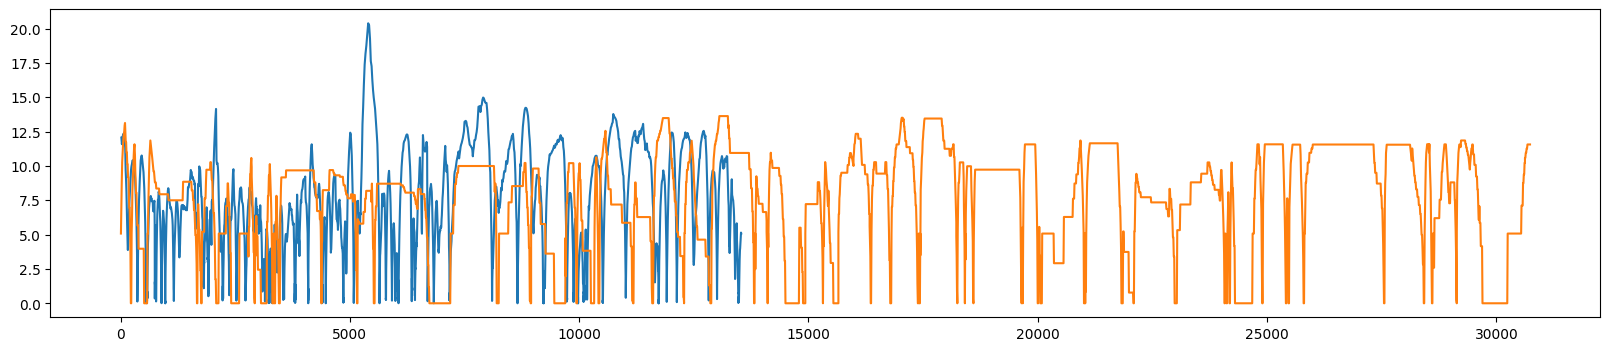

In [314]:
def runfunction_load(params):
    arg1, arg2,arg3,arg4,arg5,arg6,arg7,arg8,arg9 = params
    #print(params)
    route = gt.load_from_json(list(selected_route_instances.path)[3])
    bus = op.load_bus_params(selected_route_instances.iloc[3].bus)
    trip = op.load_trip_params(trip_path)
    trip.m_riders = arg1
    trip.traffic = arg2
    trip.chance_sig = arg3
    trip.v_wind = arg4
    trip.wind_bearing = gt.compass_heading(arg5)
    trip.seed=arg6
    ess = op.load_ESS_params(ESS_path)
    ess.P_aux = arg7
    bus.f_br = arg8
    bus.f_a = arg9
    res = process_result_list([ts.simulate_trip(route, trip, bus, ess)], ess).iloc[0]
    model_v = res['vel']
    model_dx = res['dx']
    model_dt = res['dt']
    model = pd.DataFrame([model_v, model_dx, model_dt]).T
    model.columns = ['m_v', 'm_gdx', 'm_dt']
    mix = pd.concat([r45roll, (r45roll['geodesic'].cumsum()*1000).apply(lambda x: model.iloc[list((model['m_gdx'].cumsum()-x).abs().sort_values().index)[0]])], axis=1)
    return mix

opt_res = runfunction_load([46.28215618629413, 0, 0.2, 7.871459520166802, 224.62599944500207, 55.4673320778263, 6882.453113667151, 0.4358382971737459, 0.011166249405411055])
fig, ax = plt.subplots(1, 1, figsize = (20, 4), dpi=100)
ax.plot(opt_res['geodesic'].cumsum()*1000, opt_res['v'])
ax.plot(opt_res['m_gdx'].cumsum(), opt_res['m_v'])

In [308]:
(opt_res['geodesic']*1000).cumsum()

10          7.822187
11         18.714706
12         30.281338
13         42.287418
14         54.519396
15         66.840193
16         79.001894
17         90.938420
18        102.268029
19        111.959393
20        120.924499
21        129.042584
22        135.947730
23        142.071826
24        147.397982
25        152.128753
26        156.264594
27        160.140930
28        164.294473
29        169.119886
30        174.117783
31        179.738403
32        186.424041
33        193.806229
34        201.693974
35        210.257778
36        219.321537
37        229.022070
38        238.994050
39        249.134930
40        259.511252
41        269.927962
42        280.133038
43        290.202424
44        300.303084
45        309.895846
46        318.957483
47        327.246202
48        334.982576
49        341.749083
50        347.742205
51        352.772267
52        356.997059
53        360.498674
54        363.055564
55        364.996188
56        366.385933
57        367

In [291]:
bestmse = 9999
lastmse=999
def runfunction(params):
    arg1, arg2,arg3,arg4,arg5,arg6,arg7,arg8,arg9 = params
    #print(params)
    route = gt.load_from_json(list(selected_route_instances.path)[3])
    bus = op.load_bus_params(selected_route_instances.iloc[3].bus)
    trip = op.load_trip_params(trip_path)
    trip.m_riders = arg1
    trip.traffic = arg2
    trip.chance_sig = arg3
    trip.v_wind = arg4
    trip.wind_bearing = gt.compass_heading(arg5)
    trip.seed=arg6
    ess = op.load_ESS_params(ESS_path)
    ess.P_aux = arg7
    bus.f_br = arg8
    bus.f_a = arg9
    res = process_result_list([ts.simulate_trip(route, trip, bus, ess)], ess).iloc[0]
    model_v = res['vel']
    model_dx = res['dx']
    model_dt = res['dt']
    model = pd.DataFrame([model_v, model_dx, model_dt]).T
    model.columns = ['m_v', 'm_gdx', 'm_dt']
    mix = pd.concat([r45roll, (r45roll['geodesic'].cumsum()*1000).apply(lambda x: model.iloc[list((model['m_gdx'].cumsum()-x).abs().sort_values().index)[0]])], axis=1)
    
    r2 = rsq(mix['v'], mix['m_v'])
    mseval = mse(mix['v'],mix['m_v'])

    global bestmse
    if mseval < bestmse:
        #print(r2, mseval)
        #print(arg1, arg2, arg3, arg4, arg5, arg6, arg7, arg8, arg9)
        bestmse = mseval
    
    global lastmse
    msechange = mseval-lastmse
    #print(msechange)
    lastmse=mseval
    return abs(1-r2)

#result = optimize.fmin(runfunction, [30,.1, .1, 1, 180, 0, 7000, .5, .2])
'''#, bounds=[selected_route_instances.iloc[3].ridership_min_max,
                                                                                   traffic_min_max,
                                                                                   signal_min_max,
                                                                                   wind_speed_min_max,
                                                                                   wind_directions_min_max,
                                                                                   (0, 100),
                                                                                   p_aux_min_max,
                                                                                   b_factors,
                                                                                   a_factors])'''
#result


'#, bounds=[selected_route_instances.iloc[3].ridership_min_max,\n                                                                                   traffic_min_max,\n                                                                                   signal_min_max,\n                                                                                   wind_speed_min_max,\n                                                                                   wind_directions_min_max,\n                                                                                   (0, 100),\n                                                                                   p_aux_min_max,\n                                                                                   b_factors,\n                                                                                   a_factors])'

In [221]:
for entry in result:
    print(entry)
'''
29.678845096272884
0.10132769905500502
0.10132769918399384
1.0132769909940145
180.67103083799432
6.070030969198623e-05
7036.760610720762
0.5066384962852315
0.19464013651909756
'''

29.678845096272884
0.10132769905500502
0.10132769918399384
1.0132769909940145
180.67103083799432
6.070030969198623e-05
7036.760610720762
0.5066384962852315
0.19464013651909756


In [325]:
def calculate_statistics_from_hist(vals, bins, bcon):
    mids = 0.5*(bins[1:] + bins[:-1])
    mean = np.average(mids, weights=vals)
    std = np.sqrt(np.average((mids-mean)**2, weights=vals))
    print("", end='\r')
    return mean, std

|████████████████████████████████████████| 97/97 [100%] in 0.0s (20390.66/s) 
|████████████████████████████████████████| 97/97 [100%] in 1.0s (94.74/s) 


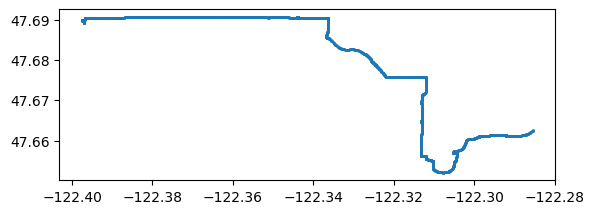

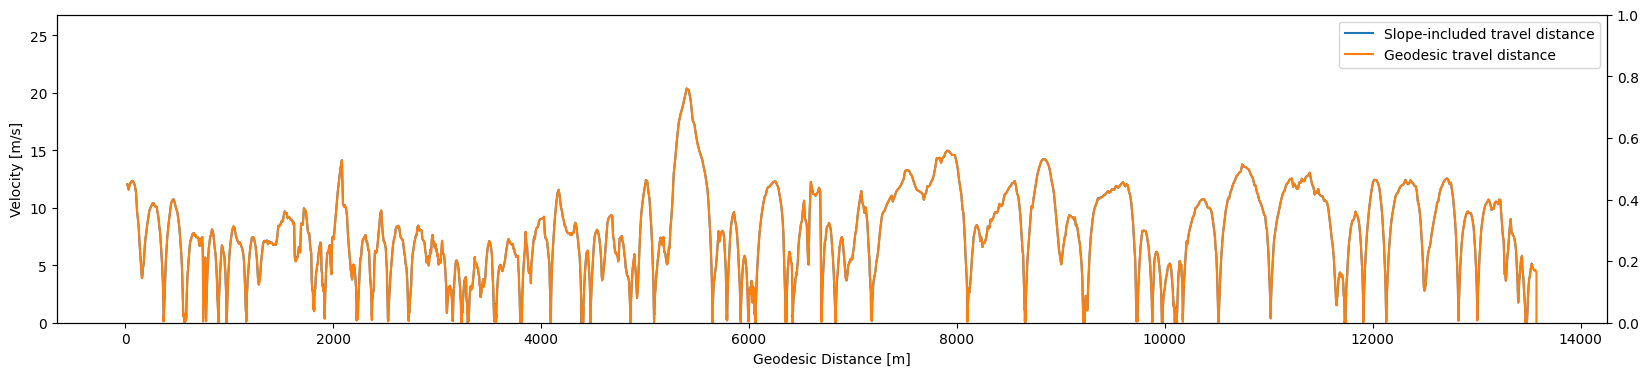

R^2 of travel distance velocity vs geodesic distance velocity: 0.9996625889534604


In [326]:
r45 = gpd.read_file("/media/sebastian/Slepnir/Location GPS 2025-02-19 15-48-40/Raw Data.csv")[:-1][:]
def parsecoord(string):
    offby = float(string.split("E")[1])
    val = float(string.split("E")[0])
    val = val*(10**offby)
    return val

DSM_rasters_list= gt.get_rasterfiles(dsm_raster_path)#+ "_reproject.tif"
DSM_rasters_list = DSM_rasters_list[DSM_rasters_list.apply(lambda x: 'reproject' in x) == False].reset_index(drop=True)
reprojected_DSMs = gt.reproject_rasterfiles(DSM_rasters_list, verbose=False)

r45['lat'] = r45['Latitude (°)'].apply(parsecoord)#.apply(lambda x: np.round(x, 5))
r45['lon'] = r45['Longitude (°)'].apply(parsecoord)#.apply(lambda x: np.round(x, 5))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
r45roll = r45[['lat','lon','Time (s)']].rolling(10).mean()[10:]
r45roll['geometry']= r45roll.apply(lambda x: shapely.Point(x.lon, x.lat), axis=1)
r45roll = gpd.GeoDataFrame(r45roll)
r45roll.set_crs(epsg=4326)
r45roll.plot(markersize = 1)
r45roll['geodesic'] = gt.query_distance_traveled(r45roll['geometry'].apply(lambda x: shapely.ops.transform(gt._flip, x)))
r45roll['raster_elev'] = gt.query_elevation_series(r45roll['geometry'].apply(lambda x: shapely.ops.transform(gt._flip, x)), reprojected_DSMs)*0.3048
r45roll['raster_elev_2'] = pd.Series(gt.smooth_elevation(r45roll['raster_elev'],40,3))
r45roll['dy'] = r45roll['raster_elev_2'].diff()
r45roll['travel_dist'] = r45roll.apply(lambda x: np.sqrt(x['geodesic']**2 + x['dy']**2), axis=1)

r45roll['dt'] = r45roll['Time (s)'].diff()
r45roll['v'] = r45roll['travel_dist']/r45roll['dt']*1000
r45roll['x'] = r45roll['travel_dist'].cumsum()
r45roll['v2'] = r45roll['geodesic']/r45roll['dt']*1000

fig, ax = plt.subplots(1, 1, figsize = (20, 4), dpi=100)
ax.plot((r45roll['geodesic'].cumsum()*1000),r45roll["v"].apply(float))
ax.plot((r45roll['geodesic'].cumsum()*1000),r45roll["v2"].apply(float))
ax.set_ylim(0, 26.8)
ax.set_xlabel("Geodesic Distance [m]")
ax.set_ylabel("Velocity [m/s]")
ax.legend(["Slope-included travel distance", "Geodesic travel distance"])
ax2 = ax.twinx()
#ax2.plot(r45roll['geodesic'].cumsum()*1000,r45roll['raster_elev'])
#ax2.plot(r45roll['geodesic'].cumsum()*1000,r45roll['raster_elev_2'])
plt.show()
r2 = 1 - (((r45roll["v"] - r45roll["v2"])**2).sum()  / ((r45roll["v2"] - r45roll["v2"].mean())**2).sum())
print("R^2 of travel distance velocity vs geodesic distance velocity: {}".format(r2))

In [327]:
# After getting the mean position over 10 points, then filtering the dsm elevation with a savisky golay filter of 70, 3, the geodesic and travel distance velocities
# almost perfectly line up. 

Index(['miles', 'kwh', 'tot_time', 'v', 'dt', 'g', 'vel', 'dx'], dtype='object')


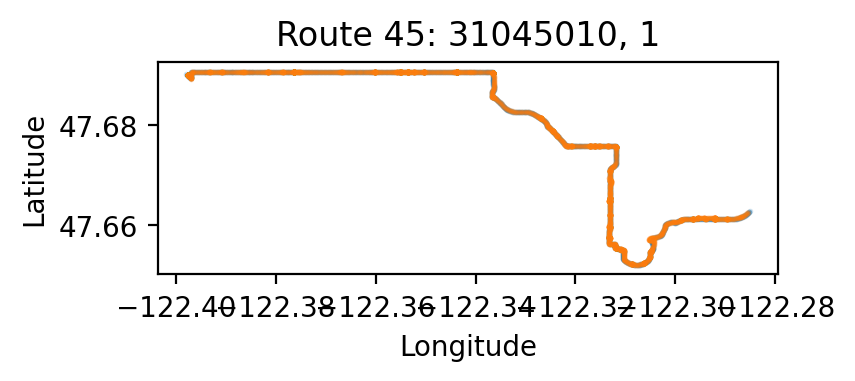

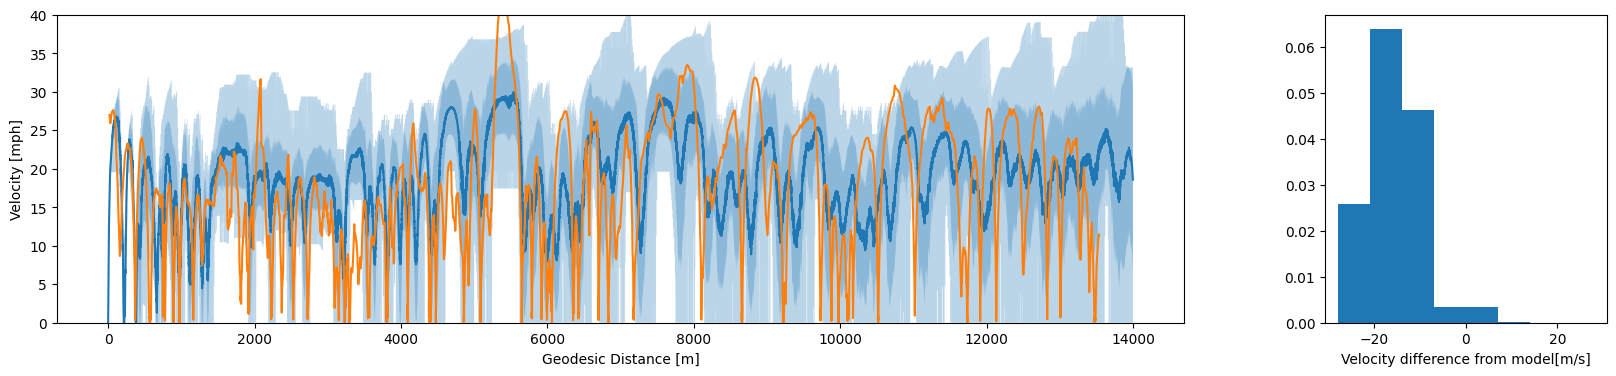

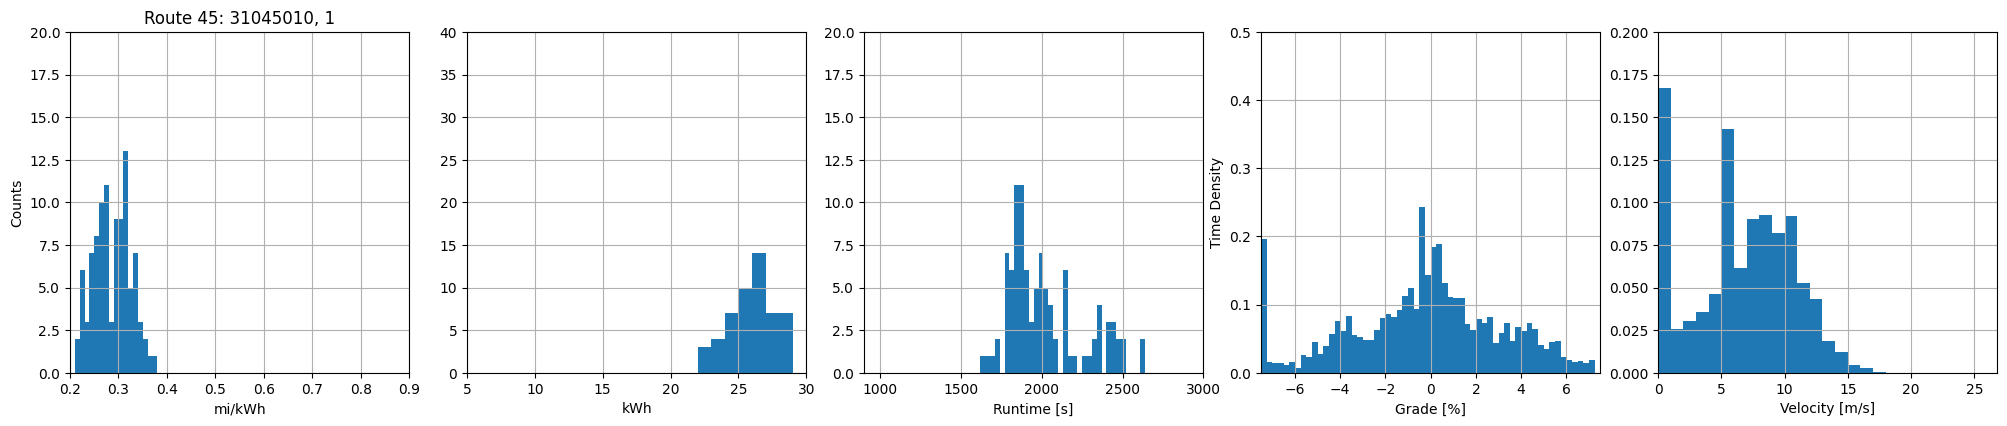

Benchmark Velocity Mean: 3.9188412973617637 m/s, STD: 3.9682464471831627 m/s, min:  m/s, max: m/s
Model MSE: 273.3996593040562
Time spent in : std: 102.00002179849957 s, in bounds: 2099.3649520056993 s, above bounds 1.9979890231000006 s, below bounds 1373.107639730601 s
-------------------------------------------model statistics---------------------------------------
Milage min/max/mean/std [mi/kWh]: 	(0.21751417982578716, 0.37150501900830385, 0.28732717492161536, 0.03734763984074167)
Energy min/max/mean/std [kWh]: 		(22.20316010809442, 37.92205834400562, 29.203596883474674, 3.889315102644838)
Time min/max/mean/std [s]: 		(1635.1955297065838, 2626.1111460946377, 2020.4694009174748, 234.8259225202119)
|Grade| mean/std [%]: 			(2.354462666916538, 1.853288433522828)
Velocity mean/std [m/s]: 		(6.618806296233689, 3.9644387716680374)
--------------------------------------------------------------------------------------------------



In [328]:
# Instance, Run No.
mi_kwh_bins = np.arange(.2, .9, .01)
kwh_bins = np.arange(5, 30, 1)
volt_bins = np.arange(20, 50, .5)
time_bins = np.arange(15*60, 50*60, 30)
grade_bins = np.arange(-7.5, 7.5, .25)
vel_bins = np.arange(0, 26.822, 1)
for index, row in selected_route_instances[3:4].iterrows():
    # Plot the path --------------------------
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=200)
    gt.load_from_json(row.path).to_gdf().geometry.apply(lambda x: shapely.ops.transform(gt._flip, x)).plot(ax=ax, markersize=1, color="tab:blue", alpha = .2, zorder = 1)
    r45roll.plot(ax=ax, markersize = 1, color="tab:orange", alpha = .2, zorder = 5)
    ax.set_title("Route {}: {}, {}".format(row.shortname, row['shape'], row.direction))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    res = pd.DataFrame(row['results'])
    # Plot the velocity and envelope -------------------
    print(res.columns)
    v_list = list(res['vel'])
    x_list = list(res['dx'])
    
    frame_list = []
    for i in range(len(v_list[:])):
        indiv_frame = pd.DataFrame([v_list[i], x_list[i]]).T

        indiv_frame['dx']=indiv_frame['gdx'].cumsum()
        frame_list.append(indiv_frame)

    expected_v_frame = pd.concat(frame_list).reset_index(drop=True)
    expected_v_frame['v_f'] = expected_v_frame['v_f']*2.236
    expected_v_frame = expected_v_frame.sort_values('dx')
    v_means = expected_v_frame['v_f'].rolling(window=100).mean()
    v_max = expected_v_frame['v_f'].rolling(window=100).max()
    v_min = expected_v_frame['v_f'].rolling(window=100).min()
    x_means = expected_v_frame['dx'].rolling(window=100).mean()
    v_std = expected_v_frame['v_f'].rolling(window=100).std()
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 4), dpi=100, width_ratios=[4,1])

    
    ax[0].plot(x_means, v_means, zorder=1)
    ax[0].fill_between(x_means, v_means-v_std,v_means+v_std,alpha=.3,zorder = .5)
    ax[0].fill_between(x_means, v_min,v_max,alpha=.3,zorder = .2, color="tab:blue",edgecolor="None")
    
    #ax[0].plot(r45['geodesic'].cumsum()*1000,r45["Speed (m/s)"].apply(float)*2.236)
    ax[0].plot(r45roll['geodesic'].cumsum()*1000,r45roll["v"].apply(float)*2.236)
    ax[0].set_ylim(0, 40)
    ax[0].set_xlabel("Geodesic Distance [m]")
    ax[0].set_ylabel("Velocity [mph]")
    evfr = expected_v_frame.rolling(window=100).mean()[100:].reset_index(drop=True)
    evfr['std'] = v_std[100:]
    evfr['min'] = v_min[100:]
    evfr['max'] = v_max[100:]
    
    # Use the geodesic distance and find the closest index in the evfr to turn into a dataframe that is then combined with the existing r45mix
    r45mix = pd.concat([r45roll, (r45roll['geodesic'].cumsum()*1000).apply(lambda x: evfr.iloc[list((evfr['dx'].cumsum()-x).abs().sort_values().index)[0]])], axis=1)
    
    statbins = [4*round(-v_std.mean()),
                3*round(-v_std.mean()),
                2*round(-v_std.mean()), 
                round(-v_std.mean()),
                round(v_std.mean()),
                2*round(v_std.mean()),
                3*round(v_std.mean()),
               4*round(v_std.mean())]
    ax[1].hist(r45mix['v']-r45mix['v_f'], bins=statbins, density=True)
    ax[1].set_xlabel("Velocity difference from model[m/s]") # positive is an overapproximation, negative is underapproximating
    
    plt.show()
    
    # Plot the statistics ----------------
    fig, ax = plt.subplots(1, 5, figsize = (20,4), dpi=100)
    plt.tight_layout()
    
    
        
    milage = pd.Series(res['miles']/res['kwh'])
    mimin, mimax, mimean, mistd = milage.min(), milage.max(), milage.mean(), milage.std()
    ax[0].hist(milage, bins=mi_kwh_bins)
    ax[0].set_ylim(0, 20)
    ax[0].set_xlim(.2, .9)
    ax[0].set_xlabel("mi/kWh")
    ax[0].set_ylabel("Counts")
    ax[0].set_title("Route {}: {}, {}".format(row.shortname, row['shape'], row.direction))
    ax[0].grid()
    
    ax[1].hist(res['kwh'], bins=kwh_bins)
    enmin, enmax, enmean, enstd = res['kwh'].min(), res['kwh'].max(), res['kwh'].mean(), res['kwh'].std()
    ax[1].set_ylim(0, 40)
    ax[1].set_xlabel("kWh")
    ax[1].set_xlim(5, 30)
    ax[1].grid()
    
    ax[2].hist(res['tot_time'], bins=time_bins)
    tmin, tmax, tmean, tstd = res['tot_time'].min(), res['tot_time'].max(), res['tot_time'].mean(), res['tot_time'].std()
    ax[2].set_ylim(0, 20)
    ax[2].set_xlim(15*60, 50*60)
    ax[2].set_xlabel("Runtime [s]")
    ax[2].grid()


    t = pd.concat(list(res['dt'])).reset_index(drop=True)
    '''
    v = pd.concat(list(res['v'])).reset_index(drop=True)
    vvals, vbins, vbcon = ax[3].hist(v, bins=volt_bins, weights=t, density=True)
    ax[3].set_xlim(20, 50)
    ax[3].set_ylim(0, .2)
    ax[3].set_xlabel("Estimated Module Voltage, all runs [V]")
    ax[3].set_ylabel("Time Density")
    ax[3].grid()
    print("Voltage:\n\tmean: {}, std: {}".format(calculate_statistics_from_hist(vvals, vbins, vbcon)))
    '''
    #ax[1,0].axis('off')
    #ax[1,1].axis('off')
    #ax[1,2].axis('off')  
    
    g = pd.concat(list(res['g'])).reset_index(drop=True)
    gvals, gbins, gbcon = ax[4-1].hist(g.apply(abs), bins=grade_bins, weights=t, density=True, alpha = 0)
    ax[4-1].hist(g, bins=grade_bins, weights=t, density=True, color='tab:blue')
    #g.hist(ax=ax[4], bins=grade_bins, weights=t, density=True)
    ax[4-1].set_xlim(-7.5, 7.5)
    ax[4-1].set_ylim(0, .5)
    ax[4-1].set_xlabel("Grade [%]")
    ax[4-1].set_ylabel("Time Density")
    ax[4-1].grid()
    
    vel = pd.concat(list(res['vel'])).reset_index(drop=True)
    velvals, velbins, velbcon = ax[5-1].hist(vel, bins=vel_bins, weights=t, density=True)
    ax[5-1].set_xlim(0, 26.822)
    ax[5-1].set_ylim(0, .2)
    ax[5-1].set_xlabel("Velocity [m/s]")
    #ax[5-1].set_ylabel("Time Density")
    ax[5-1].grid()
    
    plt.show()
    print("Benchmark Velocity Mean: {} m/s, STD: {} m/s, min:  m/s, max: m/s".format((r45roll['v']).mean(), (r45roll['v']).std()))
    print("Model MSE: {}".format(((r45mix['v'] - r45mix['v_f'])**2).mean()))
    r45mix['inrange'] = r45mix.apply(lambda x: x["v_f"]-x['std'] <= x["v"] <= x["v_f"]+x['std'], axis=1)
    trange = r45mix[r45mix['inrange']]['dt'].sum()
    
    r45mix['inbounds'] = r45mix.apply(lambda x: x["min"] <= x["v"] <= x["max"], axis=1)
    tbounds = r45mix[r45mix['inbounds']]['dt'].sum()
    
    r45mix['abounds'] = r45mix.apply(lambda x: x['max'] < x["v"] , axis=1)
    tabounds = r45mix[r45mix['abounds']]['dt'].sum()
    
    r45mix['bbounds'] = r45mix.apply(lambda x: x['min'] > x["v"] , axis=1)
    tbbounds = r45mix[r45mix['bbounds']]['dt'].sum()
    
    
    print("Time spent in : std: {} s, in bounds: {} s, above bounds {} s, below bounds {} s".format(trange, tbounds, tabounds, tbbounds))
    
    print("-------------------------------------------model statistics---------------------------------------")
    # Print the statistics
    print("Milage min/max/mean/std [mi/kWh]: \t{}".format((mimin, mimax, mimean, mistd)))
    print("Energy min/max/mean/std [kWh]: \t\t{}".format((enmin, enmax, enmean, enstd)))
    print("Time min/max/mean/std [s]: \t\t{}".format((tmin, tmax, tmean, tstd)))
    print("|Grade| mean/std [%]: \t\t\t{}".format(calculate_statistics_from_hist(gvals, gbins, gbcon)))
    print("Velocity mean/std [m/s]: \t\t{}".format(calculate_statistics_from_hist(velvals, velbins, velbcon)))
    
    print("--------------------------------------------------------------------------------------------------")
    print()
    # >>> For calculating mean, std from bins:
    #https://stackoverflow.com/questions/50786699/how-to-calculate-the-standard-deviation-from-a-histogram-python-matplotlib

In [ ]:
importlib.reload(op)
runs= selected_route_instances.iloc[:]
results = {}
for col, run in runs.iterrows():
    
    bus = op.load_bus_params(run.bus)
    route = gt.load_from_json(run.path)
    trips = []
    esses= []
    shape = run['shape']
    for seed in seeds[:1]:
        random.seed(int(seed))
        trip = op.load_trip_params(trip_path)
        trip.m_riders = random.uniform(*row.ridership_min_max)
        trip.traffic = random.uniform(*traffic_min_max)
        trip.chance_sig = random.uniform(*signal_min_max)
        trip.v_wind = random.uniform(*wind_speed_min_max)
        trip.wind_bearing = gt.compass_heading(random.randrange(*wind_directions_min_max))
        trip.seed=int(seed)
        trips.append(trip)
        ess = op.load_ESS_params(ESS_path)
        ess.P_aux = random.randrange(*(p_aux_min_max + (500,)))
        ess.bus_S_P = (42,17)
        esses.append(ess)
    args = (route, trips[0], bus, esses[0])
    result = gpd.GeoDataFrame(ts.simulate_trip(*args))[1:]
    result = result.set_geometry('geometry').set_crs(epsg=4326)
    result.geometry = result.geometry.apply(lambda x: shapely.ops.transform(gt._flip, x))
    result['BP'] = result['P'].apply(lambda x: esses[0].calc_instance_power(x))
    result['Vm'] = result['BP'].apply(lambda x: esses[0].calc_voltage_simple(x))
    if shape in results.keys():
        results[shape].append(result)
    else:
        results[shape] = []
        results[shape].append(result)
    '''
    fig, ax = plt.subplots(4, 2, figsize = (17, 16), dpi=300, gridspec_kw={'width_ratios':[4, 1.2]})

    # Versus Geodesic Distance
    ax[0, 0].plot(result['gdx'].cumsum(), result['BP'], linewidth=1, zorder=5)
    ax[0,0].set_zorder(5)
    ax[0,0].set_facecolor("None")
    ax[0,0].set_xlabel("Geodesic Distance [meters]")
    ax[0,0].set_ylabel("ESS Load [Watts]")
    ax[0,0].set_ylim(-120000,400000)
    ax[0, 0].legend(["Load"])


    ax002 = ax[0,0].twinx()
    ax002.fill_between(result['cgdx'], result['elevation'], color='#BDBDBD', zorder=0)
    ax002.set_zorder(0)
    ax002.set_ylim(0, .160)
    ax002.set_ylabel("Elevation [km]")

    stops = result[result['dx_to_next']<.5]
    ax002.scatter(stops['cgdx'], stops['elevation'], c='tab:red')
    ax002.legend(["Elevation", "Stop"])

    ax[0, 1].hist(result['BP'], bins=np.arange(-120000, 400000, 10000), weights=result['dx'], density=True)
    ax[0, 1].set_xlabel("Load [W]")
    ax[0, 1].set_ylabel("Distance Density")

    # Versus Time
    ax[1, 0].plot(result['dt'].cumsum()/60, result['BP'], linewidth=1, zorder=5)
    ax[1,0].set_zorder(5)
    ax[1,0].set_facecolor("None")
    ax[1,0].set_xlabel("Elapsed Time [min]")
    ax[1,0].set_ylabel("ESS Load [Watts]")
    ax[1,0].set_ylim(-120000,400000)
    ax[1, 0].legend(["Load"])


    ax102 = ax[1,0].twinx()
    ax102.fill_between(result['cdt']/60, result['elevation'], color='#BDBDBD', zorder=0)
    ax102.set_zorder(0)
    ax102.set_ylim(0, .160)
    ax102.set_ylabel("Elevation [km]")

    ax102.scatter(stops['cdt']/60, stops['elevation'], c='tab:red')
    ax102.legend(["Elevation", "Stop"])

    ax[1, 1].hist(result['BP'], bins=np.arange(-120000, 400000, 10000), weights=result['dt'], density=True)
    ax[1, 1].set_xlabel("Load [W]")
    ax[1, 1].set_ylabel("Time Density")

    # Voltage and time
    ax[2,0].plot(result['dt'].cumsum()/60, result['Vm'], linewidth=1, zorder=5)
    ax[2,0].set_zorder(5)
    ax[2,0].set_facecolor("None")
    ax[2,0].set_xlabel("Elapsed Time [min]")
    ax[2,0].set_ylabel("Module Voltage [V]")
    ax[2,0].set_ylim(35,42)
    ax[2, 0].plot(result['dt'].cumsum()/60, [ess.V_cell*ess.module_S_P[0]]*len(result))
    ax[2, 0].legend(["Estimated Voltage", "Nominal"])

    ax202 = ax[2,0].twinx()
    ax202.fill_between(result['cdt']/60, result['elevation'], color='#BDBDBD', zorder=0)
    ax202.set_zorder(0)
    ax202.set_ylim(0, .160)
    ax202.set_ylabel("Elevation [km]")

    ax202.scatter(stops['cdt']/60, stops['elevation'], c='tab:red')
    ax202.legend(["Elevation", "Stop"])

    ax[2, 1].hist(result['Vm'], bins=np.arange(35, 42, .2), weights=result['dt'], density=True)
    ax[2, 1].set_xlabel("Voltage [V]")
    ax[2, 1].set_ylabel("Time Density")

    # Capacity
    ax[3, 0].plot(result['dt'].cumsum()/60, (result['dt']*(result['BP']/1000)).cumsum()/3600, linewidth=1)
    ax[3, 0].legend(["Energy Used"])
    ax[3,0].set_xlabel("Elapsed Time [min]")
    ax[3,0].set_ylabel("Energy [kWh]")

    ax302 = ax[3,0].twinx()
    ax302.plot(result['dt'].cumsum()/60, ((ess.bus_E_cap()/1000 - (result['dt']*(result['BP']/1000)).cumsum()/3600)/(ess.bus_E_cap()/1000)).clip(0)*100, linewidth=1, c="tab:orange")
    ax302.set_ylabel("SOC [%]")
    ax302.legend(['ESS SOC'])
    ax302.set_ylim(0, 100)


    plt.show()

    result.plot('cdt',  markersize = 3)
    '''
    #plt.show()
    
    
for shape_group in results:
    result = gpd.GeoDataFrame(pd.concat(results[shape_group], ignore_index=True), geometry='geometry')
    result['cdt'] = result['dt'].cumsum()
    result['cgdx'] = result['gdx'].cumsum()
    
    fig, ax = plt.subplots(4, 2, figsize = (17, 16), dpi=300, gridspec_kw={'width_ratios':[4, 1.2]})

    # Versus Geodesic Distance
    ax[0, 0].plot(result['gdx'].cumsum(), result['BP'], linewidth=1, zorder=5)
    ax[0,0].set_zorder(5)
    ax[0,0].set_facecolor("None")
    ax[0,0].set_xlabel("Geodesic Distance [meters]")
    ax[0,0].set_ylabel("ESS Load [Watts]")
    ax[0,0].set_ylim(-120000,400000)
    ax[0, 0].legend(["Load"])


    ax002 = ax[0,0].twinx()
    ax002.fill_between(result['cgdx'], result['elevation'], color='#BDBDBD', zorder=0)
    ax002.set_zorder(0)
    ax002.set_ylim(0, .160)
    ax002.set_ylabel("Elevation [km]")

    stops = result[result['dx_to_next']<.5]
    ax002.scatter(stops['cgdx'], stops['elevation'], c='tab:red')
    ax002.legend(["Elevation", "Stop"])

    ax[0, 1].hist(result['BP'], bins=np.arange(-120000, 400000, 10000), weights=result['dx'], density=True)
    ax[0, 1].set_xlabel("Load [W]")
    ax[0, 1].set_ylabel("Distance Density")

    # Versus Time
    ax[1, 0].plot(result['dt'].cumsum()/60, result['BP'], linewidth=1, zorder=5)
    ax[1,0].set_zorder(5)
    ax[1,0].set_facecolor("None")
    ax[1,0].set_xlabel("Elapsed Time [min]")
    ax[1,0].set_ylabel("ESS Load [Watts]")
    ax[1,0].set_ylim(-120000,400000)
    ax[1, 0].legend(["Load"])


    ax102 = ax[1,0].twinx()
    ax102.fill_between(result['cdt']/60, result['elevation'], color='#BDBDBD', zorder=0)
    ax102.set_zorder(0)
    ax102.set_ylim(0, .160)
    ax102.set_ylabel("Elevation [km]")

    ax102.scatter(stops['cdt']/60, stops['elevation'], c='tab:red')
    ax102.legend(["Elevation", "Stop"])

    ax[1, 1].hist(result['BP'], bins=np.arange(-120000, 400000, 10000), weights=result['dt'], density=True)
    ax[1, 1].set_xlabel("Load [W]")
    ax[1, 1].set_ylabel("Time Density")

    # Voltage and time
    ax[2,0].plot(result['dt'].cumsum()/60, result['Vm'], linewidth=1, zorder=5)
    ax[2,0].set_zorder(5)
    ax[2,0].set_facecolor("None")
    ax[2,0].set_xlabel("Elapsed Time [min]")
    ax[2,0].set_ylabel("Module Voltage [V]")
    ax[2,0].set_ylim(35,42)
    ax[2, 0].plot(result['dt'].cumsum()/60, [ess.V_cell*ess.module_S_P[0]]*len(result))
    ax[2, 0].legend(["Estimated Voltage", "Nominal"])

    ax202 = ax[2,0].twinx()
    ax202.fill_between(result['cdt']/60, result['elevation'], color='#BDBDBD', zorder=0)
    ax202.set_zorder(0)
    ax202.set_ylim(0, .160)
    ax202.set_ylabel("Elevation [km]")

    ax202.scatter(stops['cdt']/60, stops['elevation'], c='tab:red')
    ax202.legend(["Elevation", "Stop"])

    ax[2, 1].hist(result['Vm'], bins=np.arange(35, 42, .2), weights=result['dt'], density=True)
    ax[2, 1].set_xlabel("Voltage [V]")
    ax[2, 1].set_ylabel("Time Density")

    # Capacity
    ax[3, 0].plot(result['dt'].cumsum()/60, (result['dt']*(result['BP']/1000)).cumsum()/3600, linewidth=1)
    ax[3, 0].legend(["Energy Used"])
    ax[3,0].set_xlabel("Elapsed Time [min]")
    ax[3,0].set_ylabel("Energy [kWh]")

    ax302 = ax[3,0].twinx()
    ax302.plot(result['dt'].cumsum()/60, ((ess.bus_E_cap()/1000 - (result['dt']*(result['BP']/1000)).cumsum()/3600)/(ess.bus_E_cap()/1000)).clip(0)*100, linewidth=1, c="tab:orange")
    ax302.set_ylabel("SOC [%]")
    ax302.legend(['ESS SOC'])
    ax302.set_ylim(0, 100)

    #ax[grades]
    ax[3, 1].hist(result['grade'].apply(abs), bins=grade_bins, weights = result['dt'], density=True)
    ax[3,1].set_xlabel("Grade [%]")
    ax[3,1].set_ylabel("Time Density")

    plt.show()
    result.plot('cdt',  markersize = 3)
print(len(results))

In [ ]:
fig, ax = plt.subplots(4, 2, figsize = (17, 16), dpi=300, gridspec_kw={'width_ratios':[4, 1.2]})

# Versus Geodesic Distance
ax[0, 0].plot(result['gdx'].cumsum(), result['BP'], linewidth=1, zorder=5)
ax[0,0].set_zorder(5)
ax[0,0].set_facecolor("None")
ax[0,0].set_xlabel("Geodesic Distance [meters]")
ax[0,0].set_ylabel("ESS Load [Watts]")
ax[0,0].set_ylim(-120000,400000)
ax[0, 0].legend(["Load"])


ax002 = ax[0,0].twinx()
ax002.fill_between(result['cgdx'], result['elevation'], color='#BDBDBD', zorder=0)
ax002.set_zorder(0)
ax002.set_ylim(0, .160)
ax002.set_ylabel("Elevation [km]")

stops = result[result['dx_to_next']<.5]
ax002.scatter(stops['cgdx'], stops['elevation'], c='tab:red')
ax002.legend(["Elevation", "Stop"])

ax[0, 1].hist(result['BP'], bins=np.arange(-120000, 400000, 10000), weights=result['dx'], density=True)
ax[0, 1].set_xlabel("Load [W]")
ax[0, 1].set_ylabel("Distance Density")

# Versus Time
ax[1, 0].plot(result['dt'].cumsum()/60, result['BP'], linewidth=1, zorder=5)
ax[1,0].set_zorder(5)
ax[1,0].set_facecolor("None")
ax[1,0].set_xlabel("Elapsed Time [min]")
ax[1,0].set_ylabel("ESS Load [Watts]")
ax[1,0].set_ylim(-120000,400000)
ax[1, 0].legend(["Load"])


ax102 = ax[1,0].twinx()
ax102.fill_between(result['cdt']/60, result['elevation'], color='#BDBDBD', zorder=0)
ax102.set_zorder(0)
ax102.set_ylim(0, .160)
ax102.set_ylabel("Elevation [km]")

ax102.scatter(stops['cdt']/60, stops['elevation'], c='tab:red')
ax102.legend(["Elevation", "Stop"])

ax[1, 1].hist(result['BP'], bins=np.arange(-120000, 400000, 10000), weights=result['dt'], density=True)
ax[1, 1].set_xlabel("Load [W]")
ax[1, 1].set_ylabel("Time Density")

# Voltage and time
ax[2,0].plot(result['dt'].cumsum()/60, result['Vm'], linewidth=1, zorder=5)
ax[2,0].set_zorder(5)
ax[2,0].set_facecolor("None")
ax[2,0].set_xlabel("Elapsed Time [min]")
ax[2,0].set_ylabel("Module Voltage [V]")
ax[2,0].set_ylim(35,42)
ax[2, 0].plot(result['dt'].cumsum()/60, [ess.V_cell*ess.module_S_P[0]]*len(result))
ax[2, 0].legend(["Estimated Voltage", "Nominal"])

ax202 = ax[2,0].twinx()
ax202.fill_between(result['cdt']/60, result['elevation'], color='#BDBDBD', zorder=0)
ax202.set_zorder(0)
ax202.set_ylim(0, .160)
ax202.set_ylabel("Elevation [km]")

ax202.scatter(stops['cdt']/60, stops['elevation'], c='tab:red')
ax202.legend(["Elevation", "Stop"])

ax[2, 1].hist(result['Vm'], bins=np.arange(35, 42, .2), weights=result['dt'], density=True)
ax[2, 1].set_xlabel("Voltage [V]")
ax[2, 1].set_ylabel("Time Density")

# Capacity
ax[3, 0].plot(result['dt'].cumsum()/60, (result['dt']*(result['BP']/1000)).cumsum()/3600, linewidth=1)
ax[3, 0].legend(["Energy Used"])
ax[3,0].set_xlabel("Elapsed Time [min]")
ax[3,0].set_ylabel("Energy [kWh]")

ax302 = ax[3,0].twinx()
ax302.plot(result['dt'].cumsum()/60, ((ess.bus_E_cap()/1000 - (result['dt']*(result['BP']/1000)).cumsum()/3600)/(ess.bus_E_cap()/1000)).clip(0)*100, linewidth=1, c="tab:orange")
ax302.set_ylabel("SOC [%]")
ax302.legend(['ESS SOC'])
ax302.set_ylim(0, 100)


plt.show()

In [266]:
import shapely
import Geography_Tools as gt
import pandas as pd
import matplotlib.pyplot as plt
import KC_Query_Tools as kcqt
import datetime

timelog = pd.read_csv("timelog_6.csv")

id_filter = timelog[timelog['rt'] == selected_route_instances['route_id'][0]]
#id_filter['bus'] = id_filter['bus'].apply(lambda x: kcqt.bus_type_finder(x) if x != "block" else "NA")
bus_filter = id_filter[id_filter['bus'].isin(['XDE60'])].reset_index(drop=True)

rundata = str(bus_filter['1'][0])
datapoint_strings = pd.Series(rundata[1:-1].replace(")), ", "))|").replace("), (", ")^(").split("|"))
datetimes = datapoint_strings.apply(lambda x: datetime.datetime(*eval(x.split("^")[0][18:])))

geometry = datapoint_strings.apply(lambda x: shapely.Point(x.split("^")[1][1:-2].split(", ")))
dt = datetimes.diff().apply(lambda x: x.total_seconds() if x == x else 0)
geotimes = pd.DataFrame([geometry, dt]).T

geotimes.columns=["geometry", "dt"]
geotimes['pt'] = geotimes['geometry'].apply(lambda x: "{},{}".format(x.x, x.y))

geometry = pd.Series(geotimes.groupby("pt")['dt'].sum().keys())
dt = pd.Series(geotimes.groupby("pt")['dt'].sum().values)
geotimes = pd.DataFrame([geometry, dt]).T
geotimes.columns=["geometry", "dt"]

geotimes['geometry'] = geotimes['geometry'].apply(lambda x: shapely.Point(x.split(",")))
geotimes = gpd.GeoDataFrame(geotimes).set_crs(epsg=4326)

geotimes['dx'] = gt.query_distance_traveled(geotimes['geometry'])*1000
geotimes['geometry'] = geotimes['geometry'].apply(lambda x: shapely.ops.transform(gt._flip, x))

geotimes['dt'] = geotimes['dt'].shift(-1)
geotimes = geotimes[:-1]

geotimes['v'] = (geotimes['dx']/geotimes['dt']).apply(float) * 2.2369
geotimes['v'] = geotimes['v'].apply(lambda x: 60*(x>60) + x*(x<60))

geotimes['t'] = (geotimes['dt'].cumsum()/60).apply(float)

#fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
#ax.plot(geotimes['t'], geotimes['v'])

In [270]:
geotimes

geometry          dt           dx          v          t
0   POINT (-122.32399 47.67818)   20.891941    86.822797   9.296116   0.348199
1   POINT (-122.32461 47.67884)   20.971234    66.073155   7.047704   0.697720
2   POINT (-122.32510 47.67933)   10.470761    76.867401  16.421413   0.872232
3   POINT (-122.32571 47.67989)   20.928551   185.328695  19.808431   1.221041
4   POINT (-122.32698 47.68132)   31.389787     4.277987   0.304858   1.744205
5   POINT (-122.32703 47.68134)   21.770065   400.539052  41.155863   2.107039
6   POINT (-122.33203 47.68259)    10.46427   174.754896  37.356569   2.281443
7   POINT (-122.32970 47.68262)   20.864192   328.344998  35.202654   2.629180
8   POINT (-122.33396 47.68330)   20.923026   325.770863  34.828463   2.977897
9   POINT (-122.33667 47.68559)   10.463642     3.835178   0.819878   3.152291
10  POINT (-122.33672 47.68560)   31.336045    76.405639   5.454159   3.674559
11  POINT (-122.33675 47.68629)   31.308928    62.228110   4.445954   4.196374
12  POINT (-122.33652 47.68682)   20.894731   230.866744  24.715600   4.544620
13  POINT (-122.33641 47.68890)   31.332655     4.447371   0.317507   5.066830
14  POINT (-122.33641 47.68894)   20.897041  4539.433066  60.000000   5.415114
15  POINT (-122.39687 47.68948)   31.365663    18.931537   1.350137   5.937876
16  POINT (-122.39713 47.68949)   20.883097    20.365679   2.181477   6.285927
17  POINT (-122.39726 47.68965)   31.393162    19.742346   1.406728   6.809147
18  POINT (-122.39741 47.68979)   763.09234     4.173592   0.012234  19.527352
19  POINT (-122.39745 47.68982)   62.696403    31.815221   1.135112  20.572292
20  POINT (-122.39774 47.69003)  868.647464    19.917007   0.051289  35.049750
21  POINT (-122.39792 47.69016)   73.447077  4615.843531  60.000000  36.273868
22  POINT (-122.33643 47.69031)    10.45465    22.244968   4.759582  36.448112
23  POINT (-122.33644 47.69051)    20.90082   214.179266  22.922431  36.796459
24  POINT (-122.33929 47.69052)   31.280844   185.062300  13.233846  37.317806
25  POINT (-122.34176 47.69054)   73.128773   179.802305   5.499884  38.536619
26  POINT (-122.34415 47.69056)     10.4618     9.158604   1.958256  38.710983
27  POINT (-122.34428 47.69056)   10.454986    92.791012  19.853132  38.885232
28  POINT (-122.34551 47.69056)   20.915239   119.214369  12.750063  39.233820
29  POINT (-122.34710 47.69057)   10.462954  3722.220856  60.000000  39.408202
30  POINT (-122.39668 47.69057)   10.454624   654.690057  60.000000  39.582446
31  POINT (-122.38796 47.69057)   10.448862   122.965479  26.324539  39.756594
32  POINT (-122.38960 47.69057)   31.347596   115.908852   8.271017  40.279054
33  POINT (-122.39114 47.69057)   20.908799   201.564292  21.564087  40.627534
34  POINT (-122.39383 47.69057)   31.458023  3270.896591  60.000000  41.151834
35  POINT (-122.35026 47.69058)   10.435951     6.305921   1.351646  41.325767
36  POINT (-122.35034 47.69058)   31.282888  2745.102658  60.000000  41.847148
37  POINT (-122.38691 47.69058)   20.861073   123.115870  13.201521  42.194833
38  POINT (-122.38527 47.69058)   20.837513  2509.155942  60.000000  42.542124
39  POINT (-122.35184 47.69059)   10.443342   187.828236  40.231660  42.716180
40  POINT (-122.35435 47.69059)   10.423739  2089.961941  60.000000  42.889909
41  POINT (-122.38219 47.69059)    31.29832  2025.926799  60.000000  43.411548
42  POINT (-122.35520 47.69060)   95.366395    35.059009   0.822339  45.000988
43  POINT (-122.35567 47.69060)   20.901564     5.705355   0.610591  45.349347
44  POINT (-122.35574 47.69060)   41.844199  1664.987819  60.000000  46.046750
45  POINT (-122.37792 47.69061)   10.455958  1521.227738  60.000000  46.221016
46  POINT (-122.35766 47.69061)   31.385526     8.032538   0.572493  46.744109
47  POINT (-122.35777 47.69061)   10.453954  1408.997254  60.000000  46.918341
48  POINT (-122.37653 47.69061)     21.1898     9.238912   0.975305  47.271504
49  POINT (-122.37641 47.69061)   10.447549     2.327184   0.498268  47.4

<Axes: >

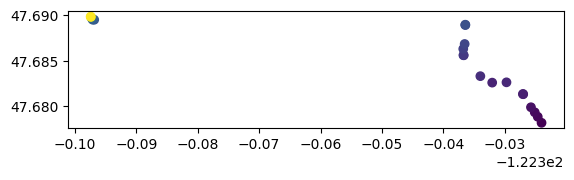

In [290]:
# Cleaning the data:
geotimes_trunc = geotimes[:20]
geotimes_trunc.plot('t')

In [291]:
geotimes_trunc

geometry         dt           dx          v          t
0   POINT (-122.32399 47.67818)  20.891941    86.822797   9.296116   0.348199
1   POINT (-122.32461 47.67884)  20.971234    66.073155   7.047704   0.697720
2   POINT (-122.32510 47.67933)  10.470761    76.867401  16.421413   0.872232
3   POINT (-122.32571 47.67989)  20.928551   185.328695  19.808431   1.221041
4   POINT (-122.32698 47.68132)  31.389787     4.277987   0.304858   1.744205
5   POINT (-122.32703 47.68134)  21.770065   400.539052  41.155863   2.107039
6   POINT (-122.33203 47.68259)   10.46427   174.754896  37.356569   2.281443
7   POINT (-122.32970 47.68262)  20.864192   328.344998  35.202654   2.629180
8   POINT (-122.33396 47.68330)  20.923026   325.770863  34.828463   2.977897
9   POINT (-122.33667 47.68559)  10.463642     3.835178   0.819878   3.152291
10  POINT (-122.33672 47.68560)  31.336045    76.405639   5.454159   3.674559
11  POINT (-122.33675 47.68629)  31.308928    62.228110   4.445954   4.196374
12  POINT (-122.33652 47.68682)  20.894731   230.866744  24.715600   4.544620
13  POINT (-122.33641 47.68890)  31.332655     4.447371   0.317507   5.066830
14  POINT (-122.33641 47.68894)  20.897041  4539.433066  60.000000   5.415114
15  POINT (-122.39687 47.68948)  31.365663    18.931537   1.350137   5.937876
16  POINT (-122.39713 47.68949)  20.883097    20.365679   2.181477   6.285927
17  POINT (-122.39726 47.68965)  31.393162    19.742346   1.406728   6.809147
18  POINT (-122.39741 47.68979)  763.09234     4.173592   0.012234  19.527352
19  POINT (-122.39745 47.68982)  62.696403    31.815221   1.135112  20.572292

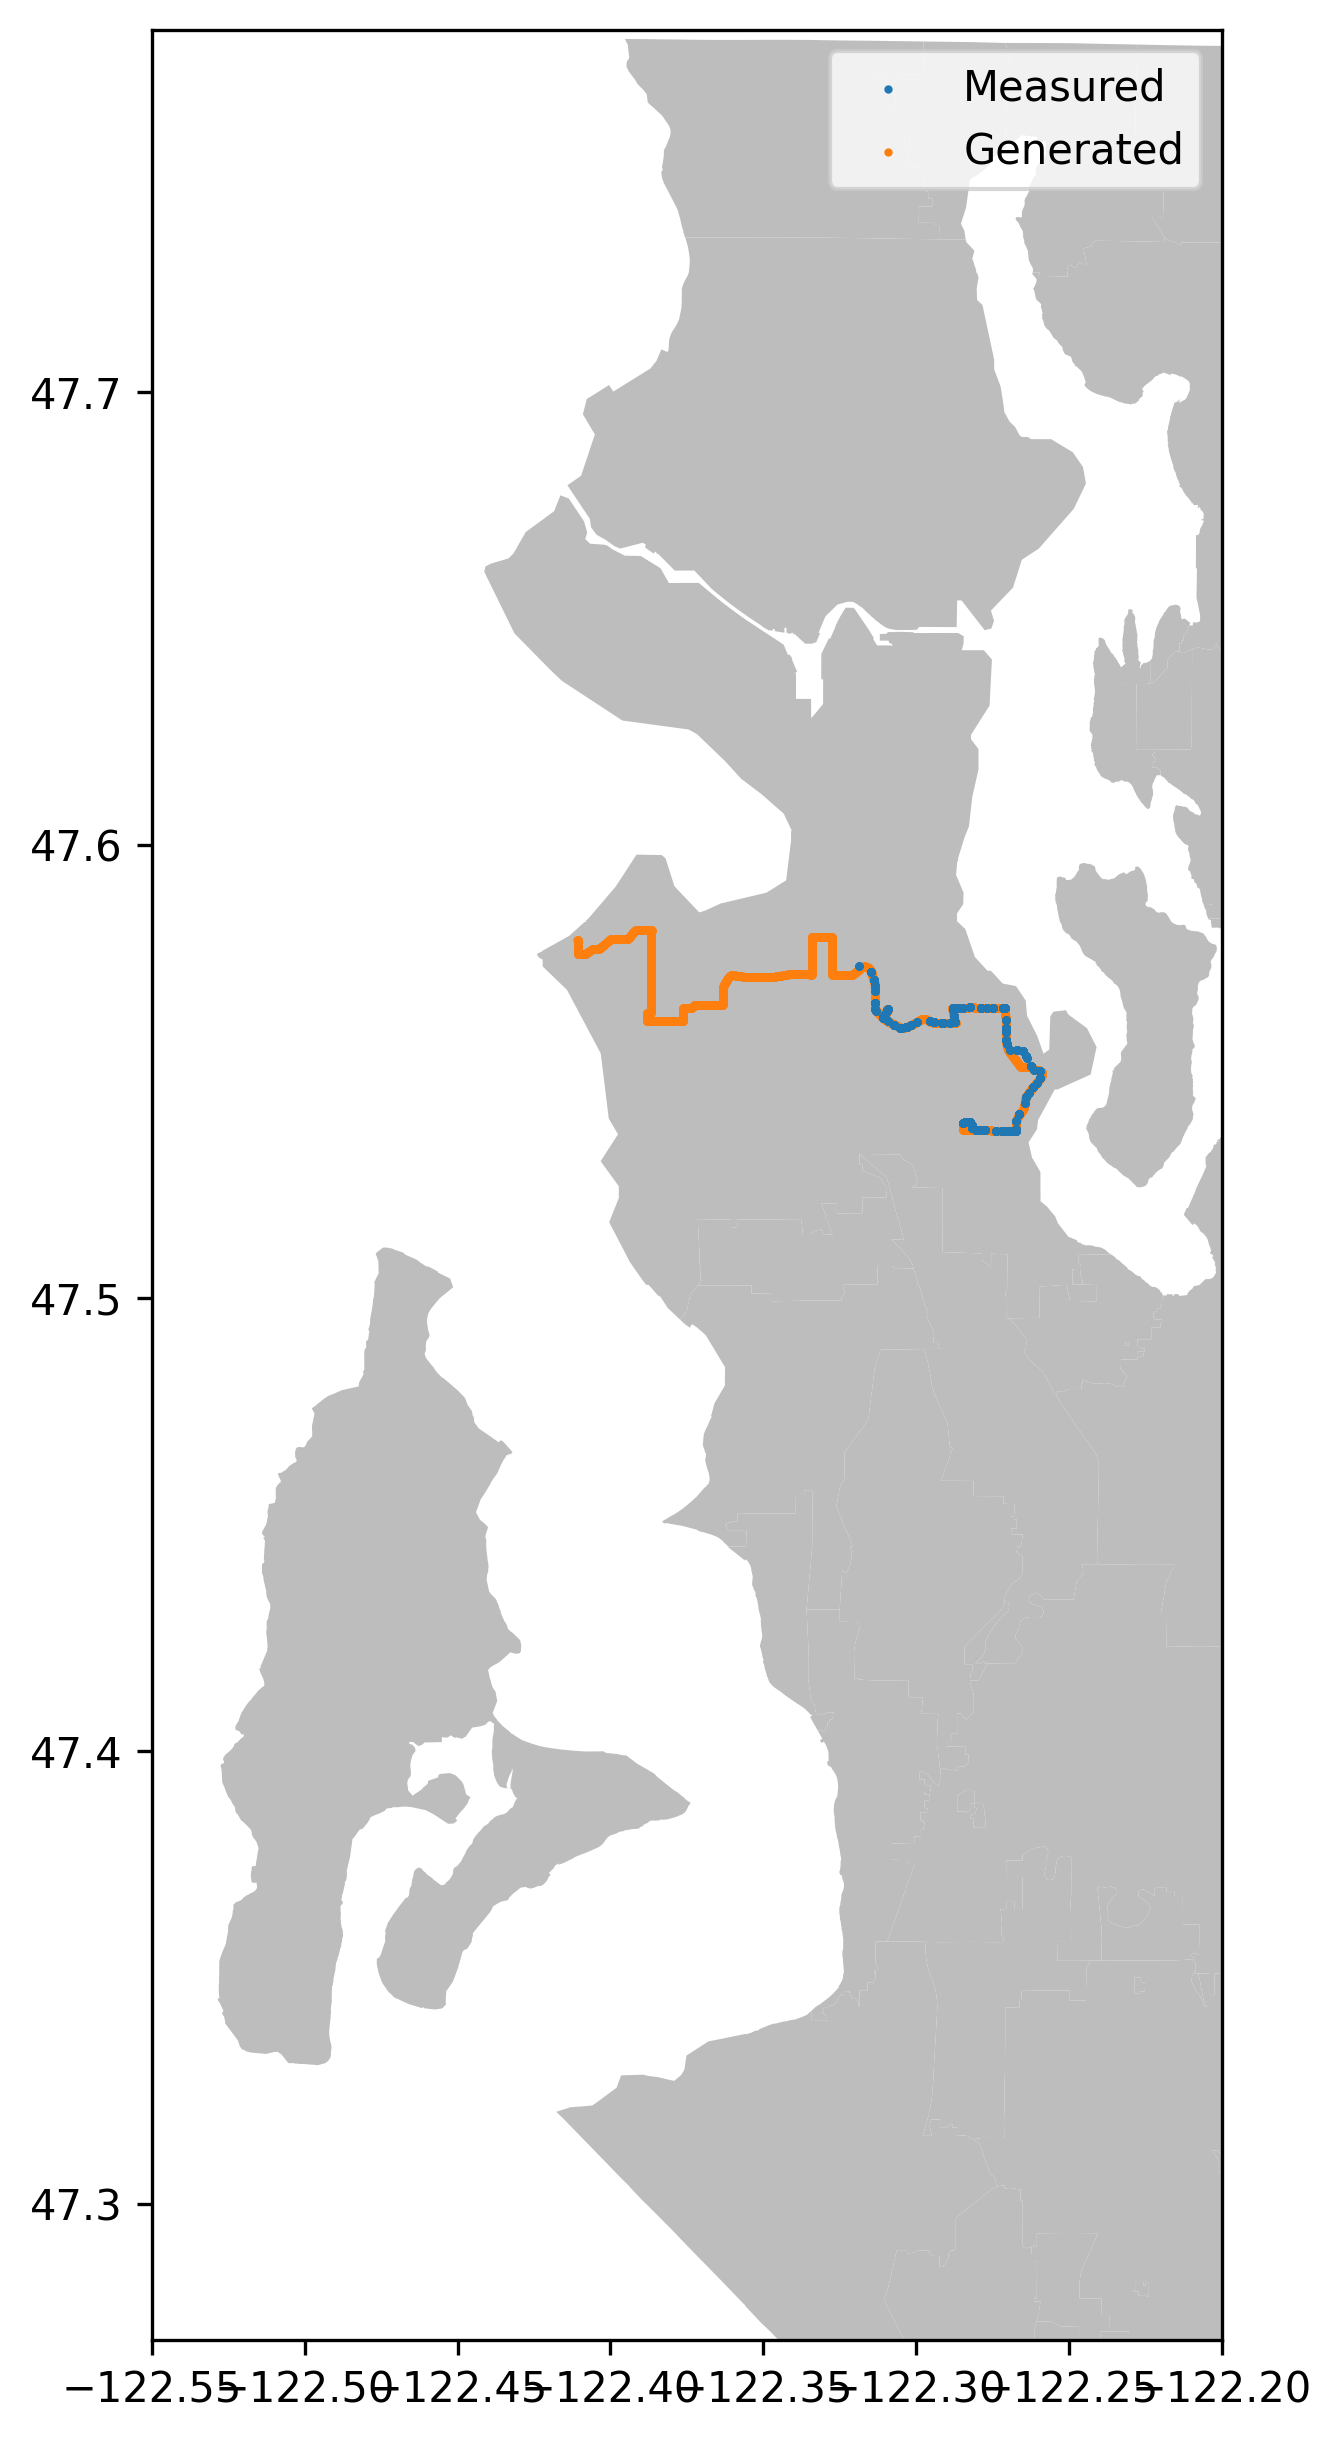

In [67]:
fig, ax = blank_kc_canvas()
gpd.GeoSeries(geometry.apply(lambda x: shapely.ops.transform(kqt._flip, x))).set_crs(epsg=4326).plot(ax=ax, zorder=5, markersize=1)
gpd.GeoSeries(gt.load_from_json(group['path'][idx]).geometry[:]).apply(lambda x: shapely.ops.transform(kqt._flip, x)).set_crs(epsg=4326).plot(ax=ax, markersize=1)
ax.set_xlim(-122.55, -122.2)
ax.set_ylim(47.27, 47.78)
ax.legend(['Measured','Generated'])

In [231]:
import KC_Route_Testing as kcrt
import importlib
import Physics_Engine as pe
import Trip_Simulator as ts
importlib.reload(pe)
importlib.reload(kcrt)
importlib.reload(ts)
importlib.reload(op)


val = xde35_routes.iloc[1:2].apply(lambda x: kcrt.run_trip(route_savepath + "rt1_sh11001003_d0.json", x.trip, x.bus, x.ESS, export_figures=True, seed_list=[1]), axis=1)

AttributeError: 'Series' object has no attribute 'trip'